In [2]:
TRAIN_DATASET_PATH = 'MICCAI_BraTS2020_TrainingData/' 
VALIDATION_DATASET_PATH = 'MICCAI_BraTS2020_ValidationData/'

In [3]:
import torch
torch.cuda.is_available()

True

Text(0.5, 1.0, 'Mask')

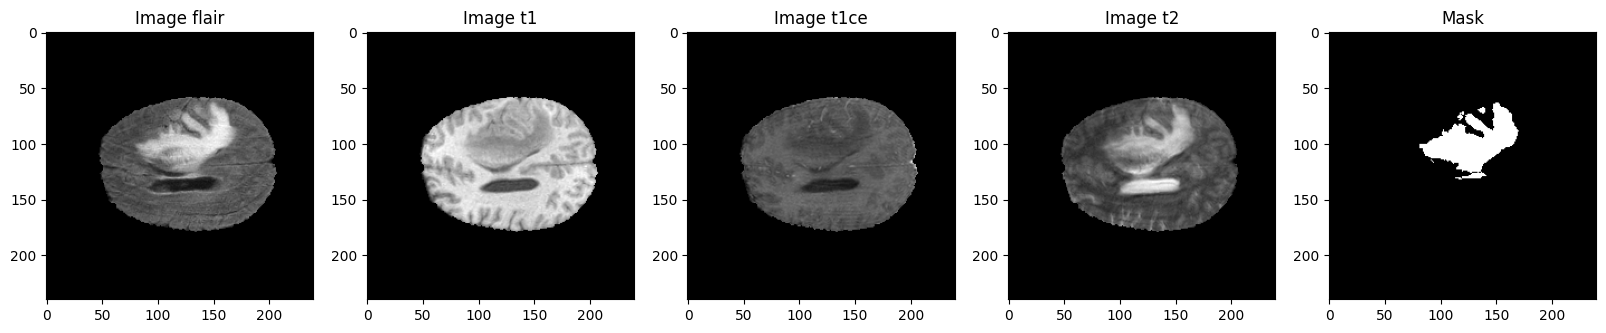

In [4]:
import nibabel as nib
from matplotlib import pyplot as plt
import os

test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz').get_fdata()
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz').get_fdata()
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii.gz').get_fdata()
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii.gz').get_fdata()
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz').get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
slice_number = test_image_flair.shape[0]//2-slice_w
ax1.imshow(test_image_flair[:,:,slice_number], cmap='gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,slice_number], cmap='gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,slice_number], cmap='gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,slice_number], cmap='gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,slice_number], cmap='gray')
ax5.set_title('Mask')

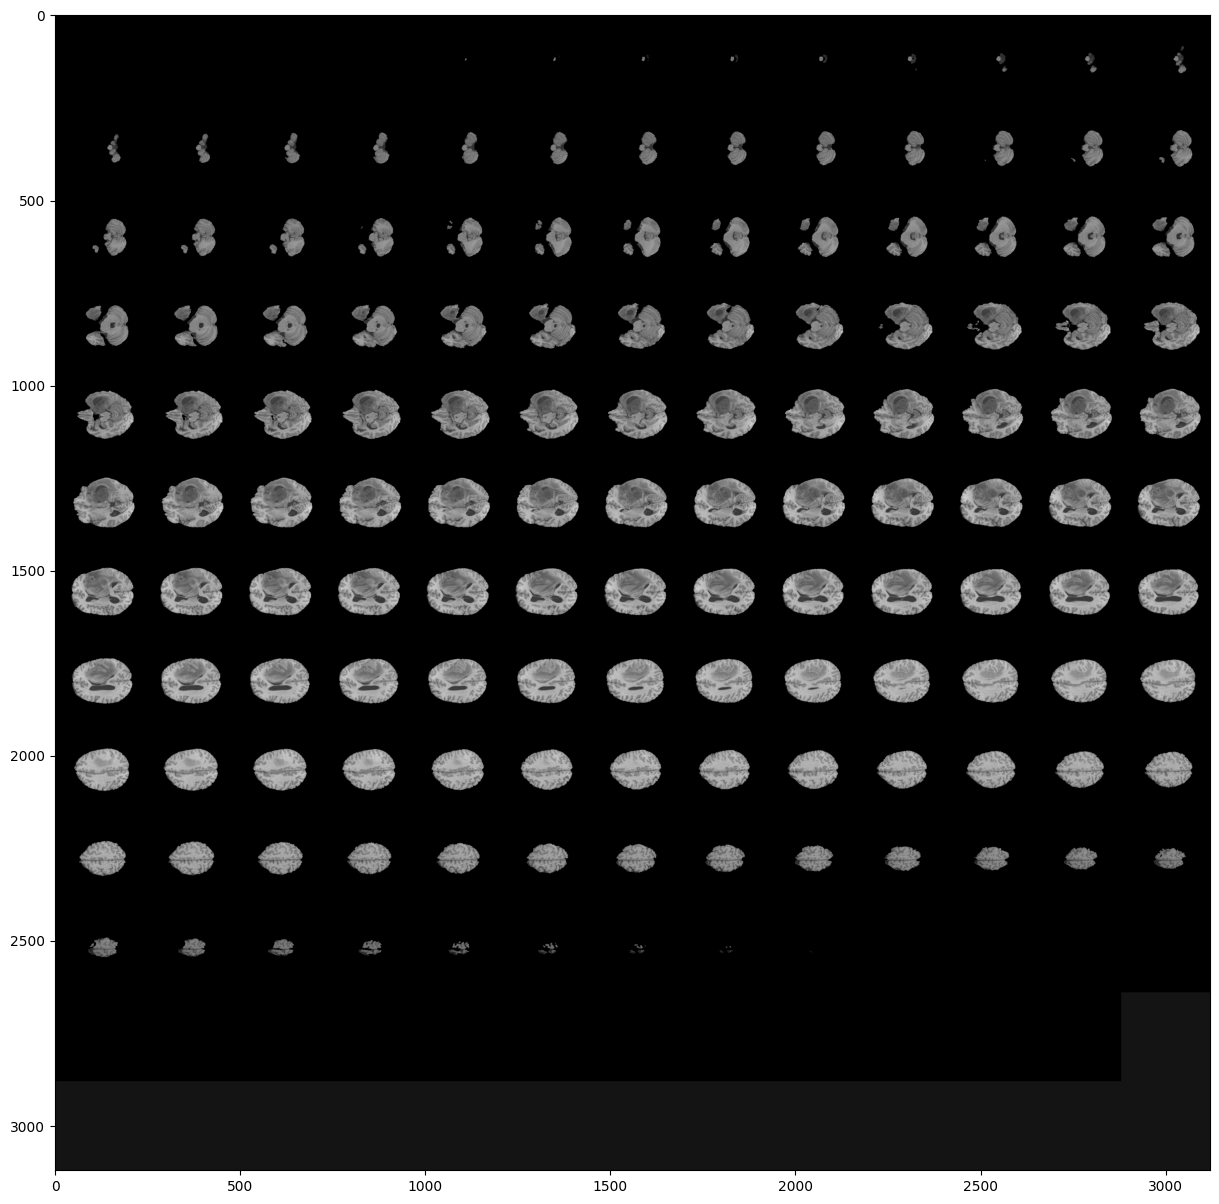

In [5]:
from skimage.util import montage
from skimage.transform import rotate
import numpy as np

# We can skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(montage(np.transpose(test_image_t1[..., :], (2, 0, 1))), cmap ='gray')

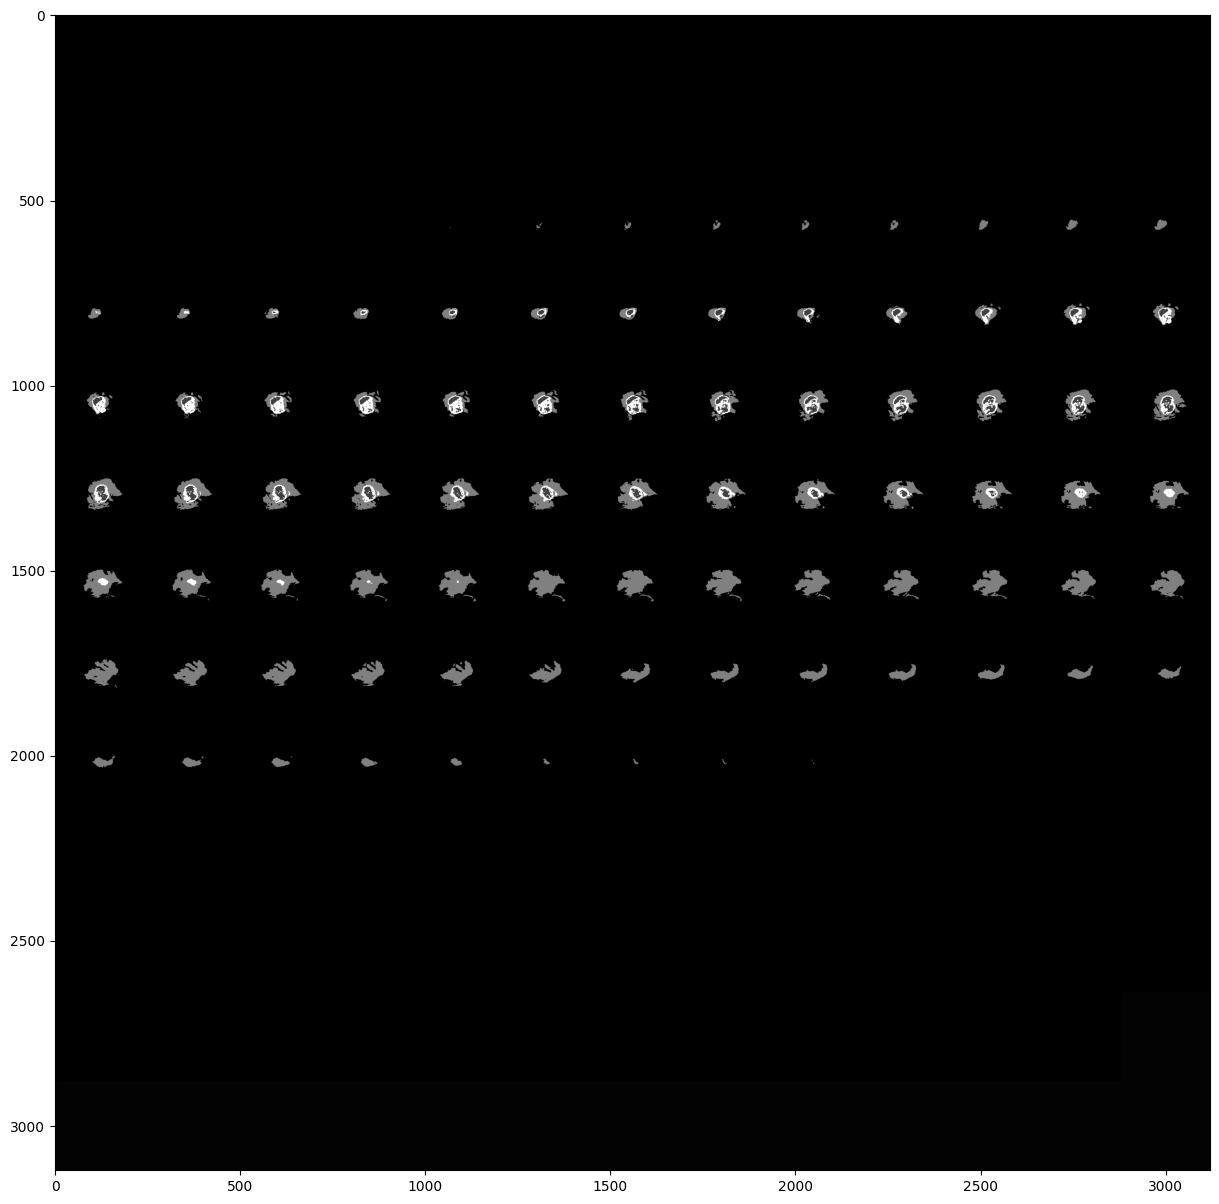

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(montage(np.transpose(test_mask[..., :], (2, 0, 1))), cmap ='gray')

In [7]:
import torch
import torch.nn as nn
def double_convolution(in_channels, out_channels):

    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels, affine=False, track_running_stats=False),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels, affine=False, track_running_stats=False),
        nn.ReLU(inplace=True)
    )
    return conv_op

In [8]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
      
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        up_1 = self.up_transpose_1(down_9)
        up_2 = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_3 = self.up_transpose_2(up_2)
        up_4 = self.up_convolution_2(torch.cat([down_5, up_3], 1))
        up_5 = self.up_transpose_3(up_4)
        up_6 = self.up_convolution_3(torch.cat([down_3, up_5], 1))
        up_7 = self.up_transpose_4(up_6)
        up_8 = self.up_convolution_4(torch.cat([down_1, up_7], 1))

        out = self.out(up_8)

        return out

In [9]:
model = UNet(num_classes=4)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
model.to(device)

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0)

In [38]:
from torchsummary import summary

summary(model, (1, 240, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]             640
       BatchNorm2d-2         [-1, 64, 240, 240]               0
              ReLU-3         [-1, 64, 240, 240]               0
            Conv2d-4         [-1, 64, 240, 240]          36,928
       BatchNorm2d-5         [-1, 64, 240, 240]               0
              ReLU-6         [-1, 64, 240, 240]               0
         MaxPool2d-7         [-1, 64, 120, 120]               0
            Conv2d-8        [-1, 128, 120, 120]          73,856
       BatchNorm2d-9        [-1, 128, 120, 120]               0
             ReLU-10        [-1, 128, 120, 120]               0
           Conv2d-11        [-1, 128, 120, 120]         147,584
      BatchNorm2d-12        [-1, 128, 120, 120]               0
             ReLU-13        [-1, 128, 120, 120]               0
        MaxPool2d-14          [-1, 128,

In [12]:
from sklearn.model_selection import train_test_split
import os

# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]



def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.15)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

print(f"Train: {len(train_ids)} | Validation: {len(val_ids)} | Test: {len(test_ids)}")

Train: 266 | Validation: 56 | Test: 47


In [13]:
import numpy as np
import nibabel as nib
def convert_labels(seg):
    """BRATS 라벨을 멀티 클래스 형태로 변환하는 함수"""
    new_seg = np.zeros((4,) + seg.shape, dtype=np.float32)  # 4개 클래스를 위한 새로운 배열

    # 각 클래스 별로 해당하는 위치에 1을 할당합니다.
    for class_index, label_value in enumerate([0, 1, 2, 4]):
        new_seg[class_index] = seg == label_value

    return new_seg

def load_dataset(ids, path):
    images_list = []
    masks_list = []
    
    for id in ids:
        t2 = nib.load(f"{path}{id}/{id}_t2.nii.gz").get_fdata()
        seg = nib.load(f"{path}{id}/{id}_seg.nii.gz").get_fdata()

        for s in range(10, seg.shape[2]-10):
            image = t2[:, :, s] / t2.max()
            mask = convert_labels(seg[:, :, s])  # 라벨 변환
            images_list.append(image)
            masks_list.append(mask)

    images = np.array(images_list, dtype=np.float32)
    images = np.expand_dims(images, axis=1)
    masks = np.array(masks_list, dtype=np.float32)  # 마스크의 shape: [N, 4, H, W]

    return images, masks

train_images, train_masks = load_dataset(train_ids, TRAIN_DATASET_PATH)
val_images, val_masks = load_dataset(val_ids, TRAIN_DATASET_PATH)

In [51]:
train_images.shape , val_masks.shape

((35910, 1, 240, 240), (7560, 4, 240, 240))

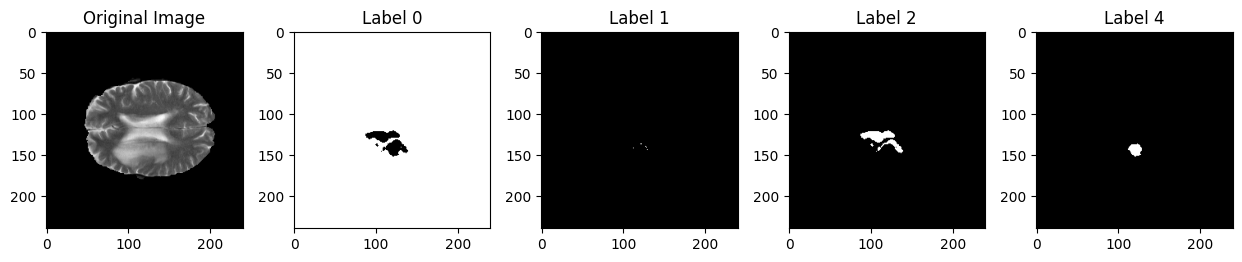

In [97]:
import matplotlib.pyplot as plt

# 원본 이미지 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)  # 5개의 마스크 + 1개의 원본 이미지 = 총 6개의 서브플롯
plt.imshow(train_images[77, 0], cmap='gray')
plt.title('Original Image')

# 각 라벨(0, 1, 2, 4)에 대한 마스크 시각화
for i, label in enumerate([0, 1, 2, 4]):
    plt.subplot(1, 6, i+2) 
    plt.imshow(train_masks[114, i], cmap='gray')
    plt.title(f'Label {label}')

plt.tight_layout()
plt.show()

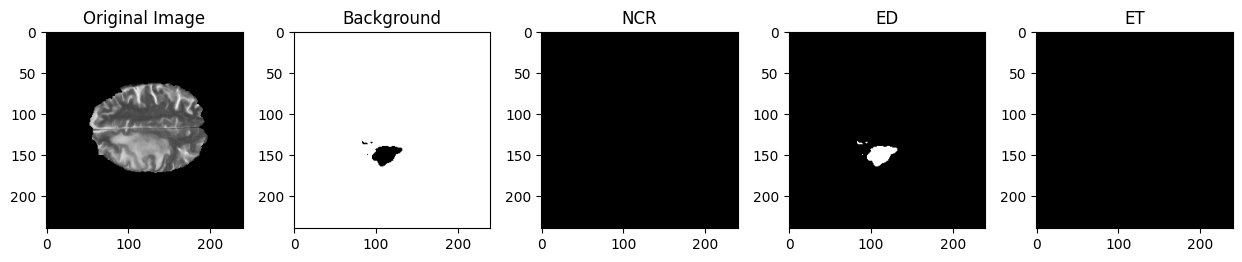

In [69]:
import matplotlib.pyplot as plt

# 사용자 지정 타이틀을 위한 라벨 매핑 사전
label_titles = {
    0: 'Background',
    1: 'NCR',
    2: 'ED',
    4: 'ET'
}

plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)  # 5개의 마스크 + 1개의 원본 이미지 = 총 6개의 서브플롯
plt.imshow(train_images[93, 0], cmap='gray')
plt.title('Original Image')

# 각 라벨에 대한 마스크 시각화 및 사용자 지정 타이틀 사용
for i, label in enumerate([0, 1, 2, 4]):
    plt.subplot(1, 6, i+2) 
    plt.imshow(train_masks[69, i], cmap='gray')
    # 사전을 통해 라벨에 해당하는 사용자 지정 타이틀을 가져옴
    plt.title(label_titles[label])

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

## multiclass diceloss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MulticlassDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MulticlassDiceLoss, self).__init__()
        self.weight = weight  # 클래스별 가중치 설정 가능

    def forward(self, inputs, targets, smooth=1):
        # inputs: 모델의 출력, shape: (N, C, H, W)
        # targets: 실제 마스크, shape: (N, C, H, W), one-hot encoded 되어있는 형태
        # N: 배치 사이즈, C: 클래스 수, H: 높이, W: 너비
        
        # softmax를 적용하여 입력 값을 확률로 변환
        inputs = F.softmax(inputs, dim=1)
        
        dice_coeff = 0.0
        for class_index in range(targets.shape[1]): # 클래스 수만큼 반복
            input_flat = inputs[:, class_index].contiguous().view(-1)
            target_flat = targets[:, class_index].contiguous().view(-1)
            
            intersection = (input_flat * target_flat).sum()
            dice = (2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
            
            if self.weight is not None:
                dice_coeff += self.weight[class_index] * dice  # 가중치 적용
            else:
                dice_coeff += dice
            
        dice_coeff /= targets.shape[1]  # 평균 Dice 계수
        
        return 1 - dice_coeff

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = TensorDataset(torch.from_numpy(train_images).type(torch.float32), torch.from_numpy(train_masks).type(torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(val_images).type(torch.float32), torch.from_numpy(val_masks).type(torch.float32))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1 of 80
Epoch 1: New best model saved with test loss: 0.70024
Train loss: 0.61514, Dice: 0.54580, BCE: 0.06933 | Test loss: 0.70024, Dice: 0.64626, BCE: 0.05398



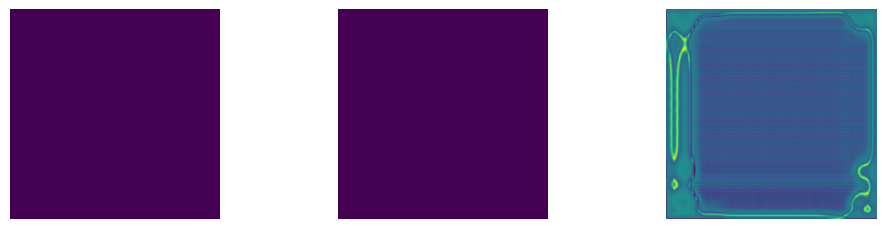

Epoch: 2 of 80
Epoch 2: New best model saved with test loss: 0.67896
Train loss: 0.47430, Dice: 0.43512, BCE: 0.03919 | Test loss: 0.67896, Dice: 0.62461, BCE: 0.05435

Epoch: 3 of 80
Epoch 3: New best model saved with test loss: 0.66078
Train loss: 0.41963, Dice: 0.38376, BCE: 0.03587 | Test loss: 0.66078, Dice: 0.61319, BCE: 0.04758

Epoch: 4 of 80
Epoch 4: New best model saved with test loss: 0.64252
Train loss: 0.37073, Dice: 0.33845, BCE: 0.03228 | Test loss: 0.64252, Dice: 0.60010, BCE: 0.04242

Epoch: 5 of 80
Epoch 5: New best model saved with test loss: 0.62741
Train loss: 0.33375, Dice: 0.30393, BCE: 0.02982 | Test loss: 0.62741, Dice: 0.58569, BCE: 0.04172

Epoch: 6 of 80
Train loss: 0.29788, Dice: 0.27083, BCE: 0.02706 | Test loss: 0.66518, Dice: 0.60734, BCE: 0.05784

Epoch: 7 of 80
Epoch 7: New best model saved with test loss: 0.62540
Train loss: 0.28156, Dice: 0.25576, BCE: 0.02579 | Test loss: 0.62540, Dice: 0.58489, BCE: 0.04051

Epoch: 8 of 80
Epoch 8: New best model s

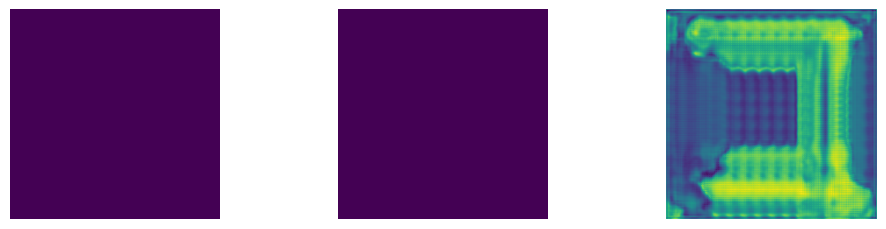

Epoch: 12 of 80
Epoch 12: New best model saved with test loss: 0.57677
Train loss: 0.20257, Dice: 0.18354, BCE: 0.01903 | Test loss: 0.57677, Dice: 0.53557, BCE: 0.04121

Epoch: 13 of 80
Epoch 13: New best model saved with test loss: 0.54383
Train loss: 0.19820, Dice: 0.17967, BCE: 0.01853 | Test loss: 0.54383, Dice: 0.50620, BCE: 0.03762

Epoch: 14 of 80
Train loss: 0.18622, Dice: 0.16863, BCE: 0.01758 | Test loss: 0.54969, Dice: 0.51160, BCE: 0.03809

Epoch: 15 of 80
Epoch 15: New best model saved with test loss: 0.53523
Train loss: 0.18073, Dice: 0.16372, BCE: 0.01701 | Test loss: 0.53523, Dice: 0.49679, BCE: 0.03845

Epoch: 16 of 80
Train loss: 0.17507, Dice: 0.15857, BCE: 0.01650 | Test loss: 0.53964, Dice: 0.50063, BCE: 0.03901

Epoch: 17 of 80
Train loss: 0.16832, Dice: 0.15243, BCE: 0.01589 | Test loss: 0.54934, Dice: 0.51006, BCE: 0.03928

Epoch: 18 of 80
Train loss: 0.16499, Dice: 0.14944, BCE: 0.01556 | Test loss: 0.56692, Dice: 0.52788, BCE: 0.03904

Epoch: 19 of 80
Train l

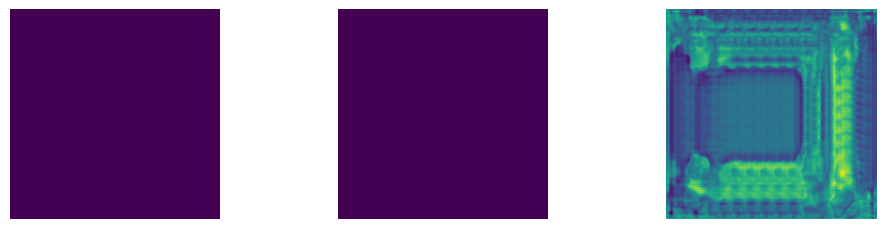

Epoch: 22 of 80
Epoch 22: New best model saved with test loss: 0.52561
Train loss: 0.14549, Dice: 0.13172, BCE: 0.01376 | Test loss: 0.52561, Dice: 0.48612, BCE: 0.03949

Epoch: 23 of 80
Epoch 23: New best model saved with test loss: 0.51433
Train loss: 0.14005, Dice: 0.12683, BCE: 0.01323 | Test loss: 0.51433, Dice: 0.47467, BCE: 0.03966

Epoch: 24 of 80
Epoch 24: New best model saved with test loss: 0.50538
Train loss: 0.13694, Dice: 0.12400, BCE: 0.01294 | Test loss: 0.50538, Dice: 0.46435, BCE: 0.04102

Epoch: 25 of 80
Epoch 25: New best model saved with test loss: 0.49577
Train loss: 0.13557, Dice: 0.12282, BCE: 0.01276 | Test loss: 0.49577, Dice: 0.45465, BCE: 0.04112

Epoch: 26 of 80
Epoch 26: New best model saved with test loss: 0.49552
Train loss: 0.13172, Dice: 0.11923, BCE: 0.01250 | Test loss: 0.49552, Dice: 0.45474, BCE: 0.04077

Epoch: 27 of 80
Epoch 27: New best model saved with test loss: 0.47742
Train loss: 0.12848, Dice: 0.11631, BCE: 0.01218 | Test loss: 0.47742, Dic

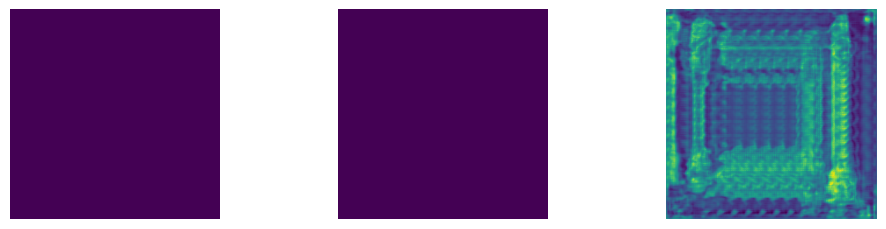

Epoch: 32 of 80
Epoch 32: New best model saved with test loss: 0.45525
Train loss: 0.11697, Dice: 0.10604, BCE: 0.01093 | Test loss: 0.45525, Dice: 0.41271, BCE: 0.04254

Epoch: 33 of 80
Epoch 33: New best model saved with test loss: 0.45466
Train loss: 0.11773, Dice: 0.10656, BCE: 0.01117 | Test loss: 0.45466, Dice: 0.40886, BCE: 0.04580

Epoch: 34 of 80
Train loss: 0.11258, Dice: 0.10190, BCE: 0.01067 | Test loss: 0.47939, Dice: 0.43724, BCE: 0.04215

Epoch: 35 of 80
Train loss: 0.11114, Dice: 0.10072, BCE: 0.01042 | Test loss: 0.46830, Dice: 0.42347, BCE: 0.04482

Epoch: 36 of 80
Train loss: 0.10946, Dice: 0.09897, BCE: 0.01049 | Test loss: 0.47800, Dice: 0.43287, BCE: 0.04513

Epoch: 37 of 80
Train loss: 0.10791, Dice: 0.09772, BCE: 0.01019 | Test loss: 0.45699, Dice: 0.41105, BCE: 0.04594

Epoch: 38 of 80
Train loss: 0.10550, Dice: 0.09555, BCE: 0.00995 | Test loss: 0.46839, Dice: 0.42580, BCE: 0.04260

Epoch: 39 of 80
Train loss: 0.10554, Dice: 0.09561, BCE: 0.00993 | Test loss: 

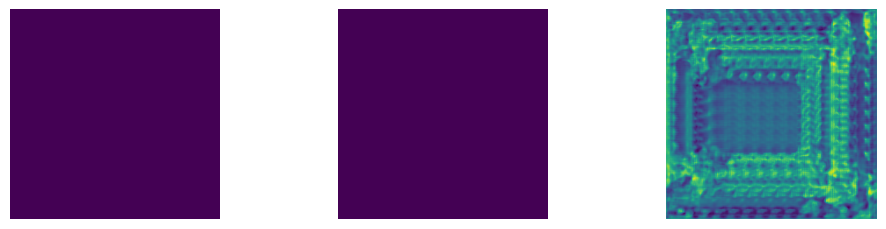

Epoch: 42 of 80
Train loss: 0.10003, Dice: 0.09059, BCE: 0.00944 | Test loss: 0.48719, Dice: 0.44513, BCE: 0.04206

Epoch: 43 of 80
Train loss: 0.09859, Dice: 0.08932, BCE: 0.00927 | Test loss: 0.47566, Dice: 0.43203, BCE: 0.04363

Epoch: 44 of 80
Train loss: 0.09912, Dice: 0.08984, BCE: 0.00928 | Test loss: 0.46839, Dice: 0.42438, BCE: 0.04401

Epoch: 45 of 80
Train loss: 0.09672, Dice: 0.08765, BCE: 0.00906 | Test loss: 0.46960, Dice: 0.42587, BCE: 0.04373

Epoch: 46 of 80
Epoch 46: New best model saved with test loss: 0.45463
Train loss: 0.09535, Dice: 0.08637, BCE: 0.00899 | Test loss: 0.45463, Dice: 0.41115, BCE: 0.04347

Epoch: 47 of 80
Train loss: 0.09386, Dice: 0.08499, BCE: 0.00887 | Test loss: 0.47532, Dice: 0.43131, BCE: 0.04401

Epoch: 48 of 80
Train loss: 0.09455, Dice: 0.08570, BCE: 0.00885 | Test loss: 0.46786, Dice: 0.42364, BCE: 0.04421

Epoch: 49 of 80
Epoch 49: New best model saved with test loss: 0.45291
Train loss: 0.09129, Dice: 0.08269, BCE: 0.00860 | Test loss: 

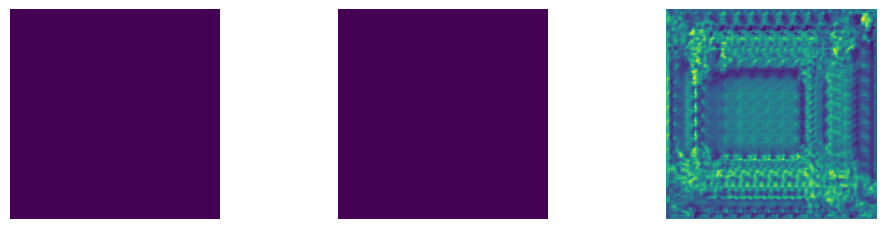

Epoch: 52 of 80
Train loss: 0.08883, Dice: 0.08044, BCE: 0.00839 | Test loss: 0.46117, Dice: 0.41668, BCE: 0.04449

Epoch: 53 of 80
Train loss: 0.08818, Dice: 0.07991, BCE: 0.00828 | Test loss: 0.46707, Dice: 0.42351, BCE: 0.04356

Epoch: 54 of 80
Epoch 54: New best model saved with test loss: 0.43522
Train loss: 0.08859, Dice: 0.08029, BCE: 0.00830 | Test loss: 0.43522, Dice: 0.38824, BCE: 0.04698

Epoch: 55 of 80
Train loss: 0.08874, Dice: 0.08028, BCE: 0.00847 | Test loss: 0.44051, Dice: 0.39591, BCE: 0.04459

Epoch: 56 of 80
Train loss: 0.08502, Dice: 0.07700, BCE: 0.00802 | Test loss: 0.45737, Dice: 0.41342, BCE: 0.04395

Epoch: 57 of 80
Train loss: 0.08524, Dice: 0.07724, BCE: 0.00800 | Test loss: 0.47647, Dice: 0.42976, BCE: 0.04671

Epoch: 58 of 80
Train loss: 0.08412, Dice: 0.07619, BCE: 0.00793 | Test loss: 0.46673, Dice: 0.42155, BCE: 0.04518

Epoch: 59 of 80
Train loss: 0.08321, Dice: 0.07537, BCE: 0.00784 | Test loss: 0.46457, Dice: 0.41878, BCE: 0.04580

Epoch: 60 of 80
T

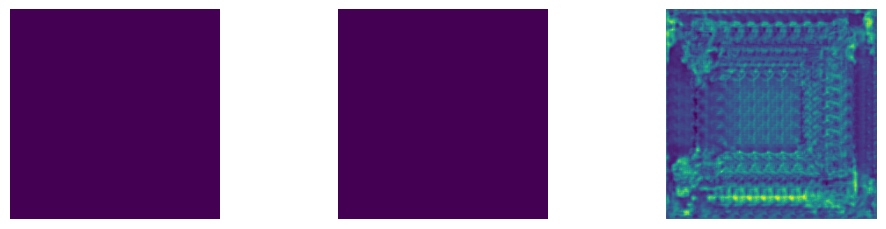

Epoch: 62 of 80
Train loss: 0.08252, Dice: 0.07480, BCE: 0.00772 | Test loss: 0.45478, Dice: 0.40938, BCE: 0.04540

Epoch: 63 of 80
Train loss: 0.08048, Dice: 0.07290, BCE: 0.00758 | Test loss: 0.46427, Dice: 0.41785, BCE: 0.04642

Epoch: 64 of 80
Train loss: 0.08173, Dice: 0.07405, BCE: 0.00768 | Test loss: 0.46233, Dice: 0.41762, BCE: 0.04472

Epoch: 65 of 80
Train loss: 0.07978, Dice: 0.07226, BCE: 0.00752 | Test loss: 0.45434, Dice: 0.40925, BCE: 0.04508

Epoch: 66 of 80
Train loss: 0.07936, Dice: 0.07187, BCE: 0.00749 | Test loss: 0.44919, Dice: 0.40085, BCE: 0.04833

Epoch: 67 of 80
Train loss: 0.07896, Dice: 0.07139, BCE: 0.00757 | Test loss: 0.45564, Dice: 0.40794, BCE: 0.04770

Epoch: 68 of 80
Train loss: 0.07817, Dice: 0.07080, BCE: 0.00737 | Test loss: 0.52151, Dice: 0.47540, BCE: 0.04611

Epoch: 69 of 80
Train loss: 0.07955, Dice: 0.07196, BCE: 0.00760 | Test loss: 0.46780, Dice: 0.42288, BCE: 0.04492

Epoch: 70 of 80
Train loss: 0.07683, Dice: 0.06957, BCE: 0.00726 | Test 

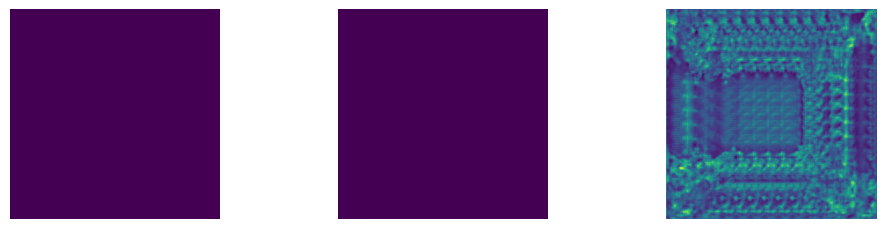

Epoch: 72 of 80
Train loss: 0.07617, Dice: 0.06898, BCE: 0.00719 | Test loss: 0.47620, Dice: 0.43032, BCE: 0.04589

Epoch: 73 of 80
Epoch 73: New best model saved with test loss: 0.43047
Train loss: 0.07520, Dice: 0.06809, BCE: 0.00711 | Test loss: 0.43047, Dice: 0.37898, BCE: 0.05150

Epoch: 74 of 80
Train loss: 0.07712, Dice: 0.06959, BCE: 0.00753 | Test loss: 0.45971, Dice: 0.41304, BCE: 0.04668

Epoch: 75 of 80
Train loss: 0.07398, Dice: 0.06696, BCE: 0.00702 | Test loss: 0.45081, Dice: 0.40466, BCE: 0.04614

Epoch: 76 of 80
Train loss: 0.07363, Dice: 0.06662, BCE: 0.00701 | Test loss: 0.47653, Dice: 0.43067, BCE: 0.04586

Epoch: 77 of 80
Train loss: 0.07367, Dice: 0.06668, BCE: 0.00699 | Test loss: 0.48098, Dice: 0.43520, BCE: 0.04578

Epoch: 78 of 80
Train loss: 0.07402, Dice: 0.06704, BCE: 0.00698 | Test loss: 0.45017, Dice: 0.40397, BCE: 0.04620

Epoch: 79 of 80
Train loss: 0.07315, Dice: 0.06620, BCE: 0.00695 | Test loss: 0.46965, Dice: 0.42426, BCE: 0.04539

Epoch: 80 of 80
T

In [ ]:
from tqdm.auto import tqdm

model = UNet(num_classes=4).to(device)

loss_fn_1 = MulticlassDiceLoss()
loss_fn_2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

best_test_loss = float('inf') 

torch.manual_seed(42)

epochs = 80

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1} of {epochs}")
    ### Training
    train_loss_1, train_loss_2, train_loss = 0, 0, 0
    
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2 Calculate loss (per batch)
        loss_1 = loss_fn_1(y_pred, y)
        loss_2 = loss_fn_2(y_pred, y)
        loss = loss_1 + loss_2
        train_loss += loss 
        train_loss_1 += loss_1
        train_loss_2 += loss_2

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_loss_1 /= len(train_dataloader)
    train_loss_2 /= len(train_dataloader)

    ### Testing
    test_loss_1, test_loss_2, test_loss = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss_1 = loss_fn_1(y_pred, y)
            loss_2 = loss_fn_2(y_pred, y)
            loss = loss_1 + loss_2
            test_loss += loss
            test_loss_1 += loss_1
            test_loss_2 += loss_2

        test_loss /= len(test_dataloader)
        test_loss_1 /= len(test_dataloader)
        test_loss_2 /= len(test_dataloader)
        
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'multiclass_best.pt')
        print(f"Epoch {epoch+1}: New best model saved with test loss: {test_loss:.5f}")
    print(f"Train loss: {train_loss:.5f}, Dice: {train_loss_1:.5f}, BCE: {train_loss_2:.5f} | Test loss: {test_loss:.5f}, Dice: {test_loss_1:.5f}, BCE: {test_loss_2:.5f}\n")
    
    if epoch % 10 == 0:
        plt.figure(figsize=(12, 6)) # 시각화 크기 조정
        plt.subplot(231)
        plt.imshow(X[6, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(232)
        plt.imshow(y[6, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(233)
        plt.imshow(y_pred[6, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.show()

In [ ]:
model = UNet(num_classes=4)

# 저장된 모델 상태 불러오기
model_path = 'multiclass_best.pt'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# 모델을 평가 모드로 전환
model.eval()

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0)

In [ ]:
print(y_pred.shape)
print(y.shape)

torch.Size([32, 4, 240, 240])
torch.Size([32, 4, 240, 240])


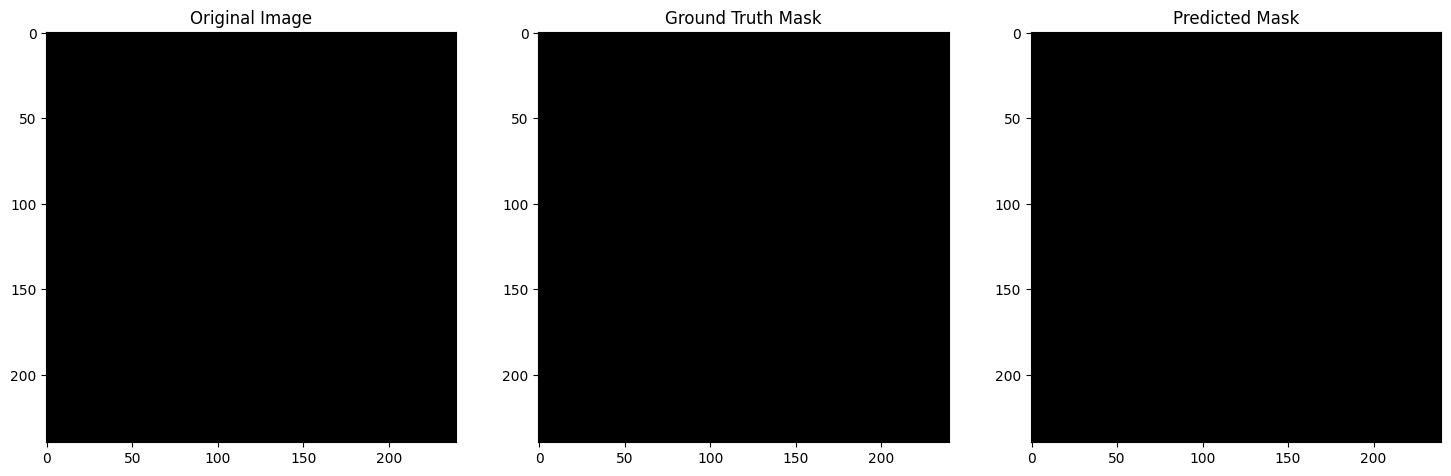

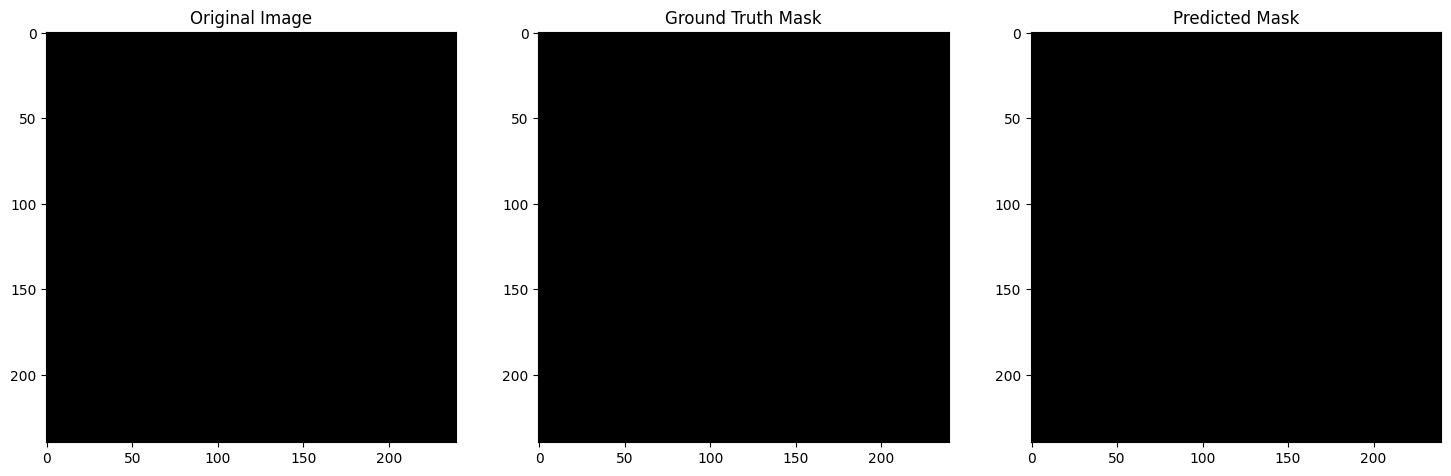

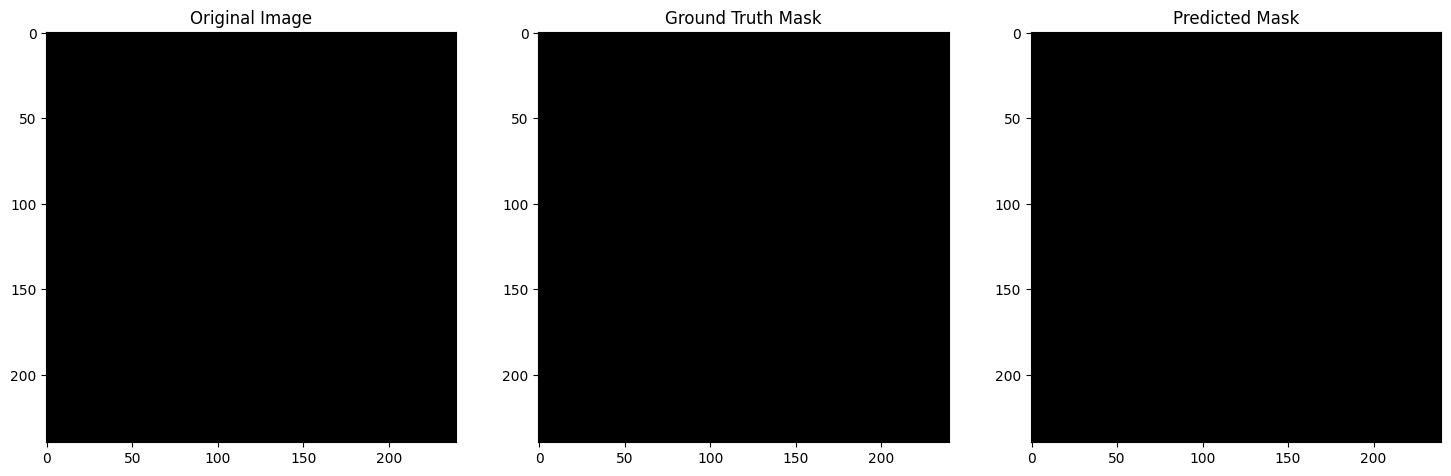

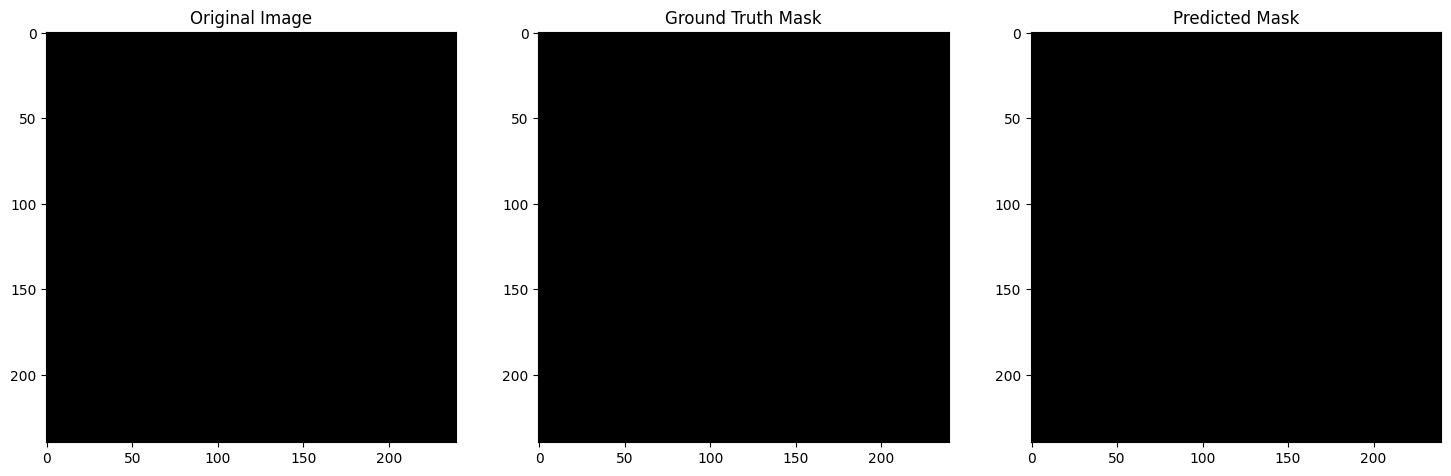

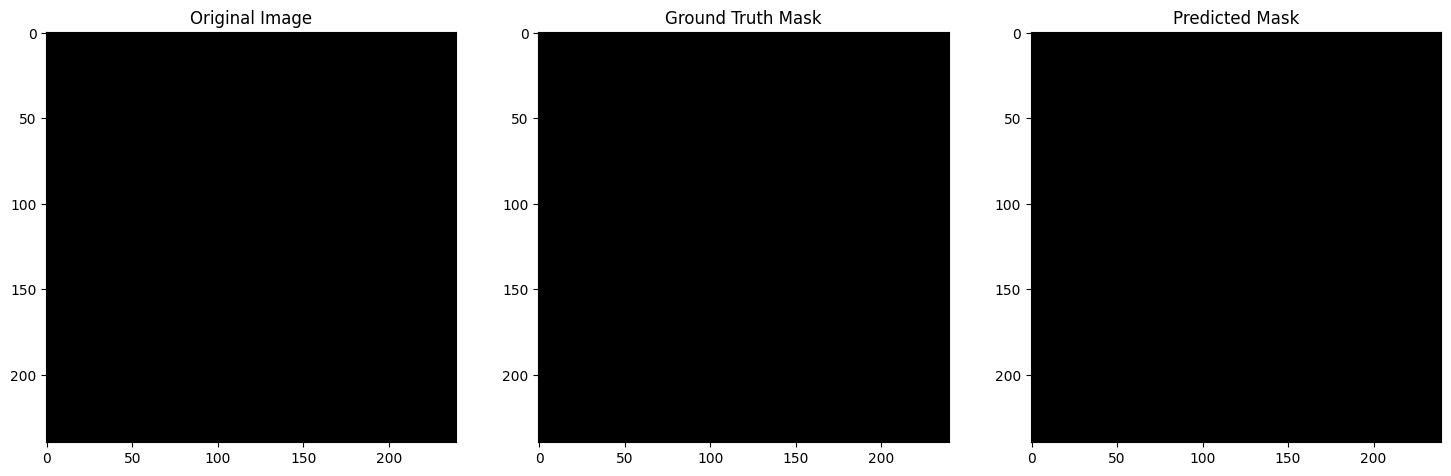

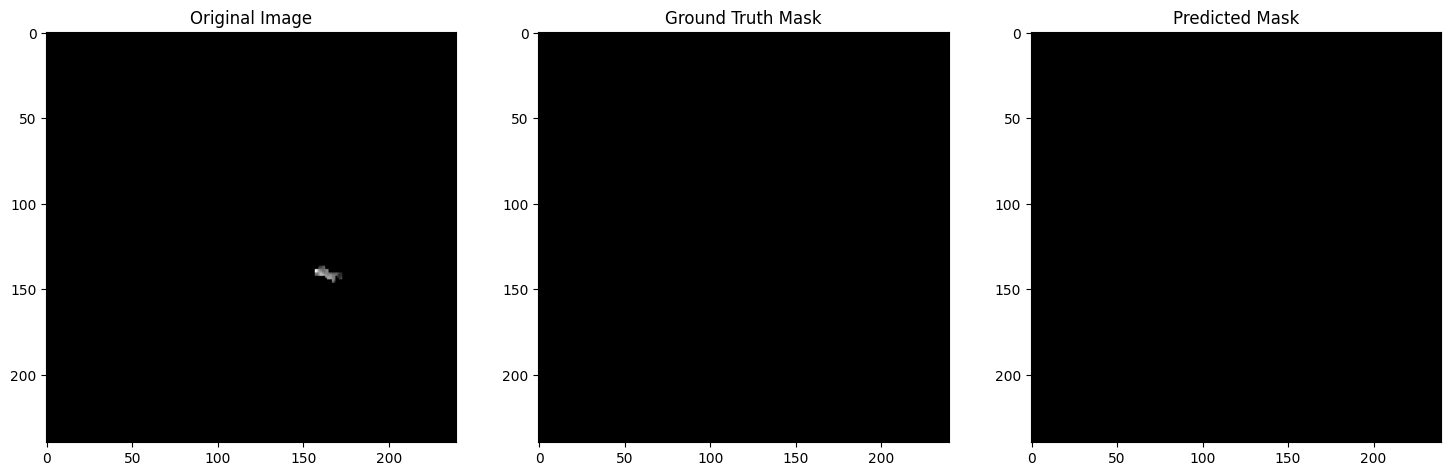

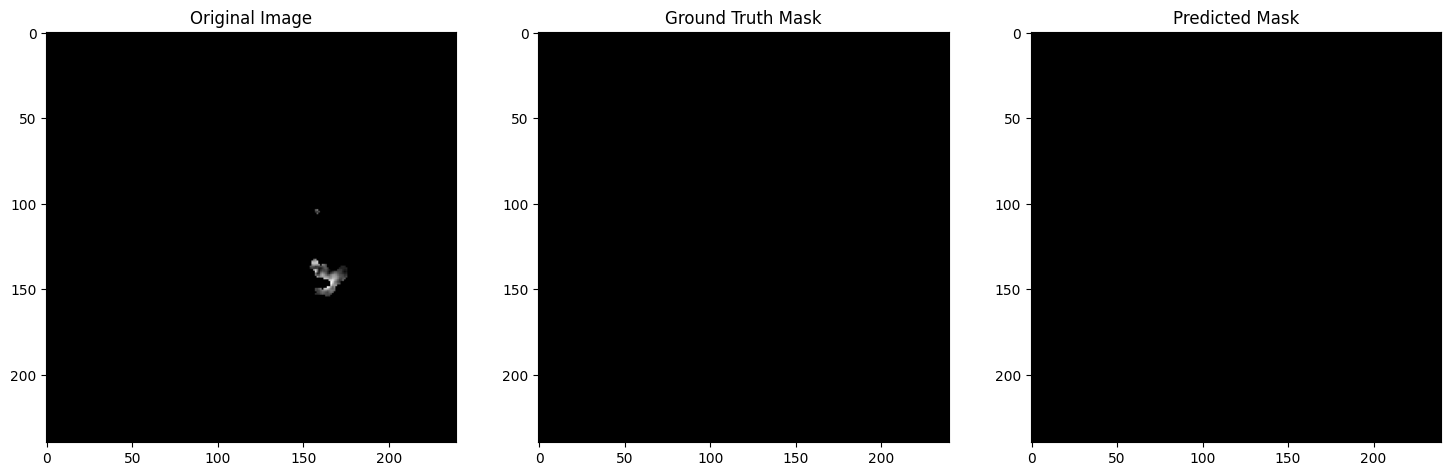

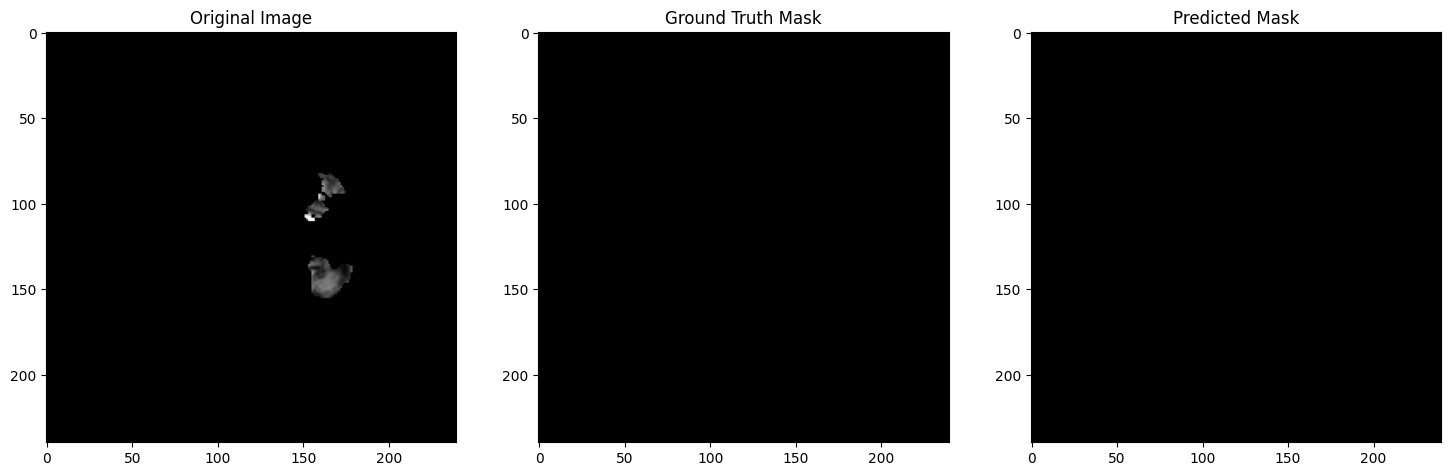

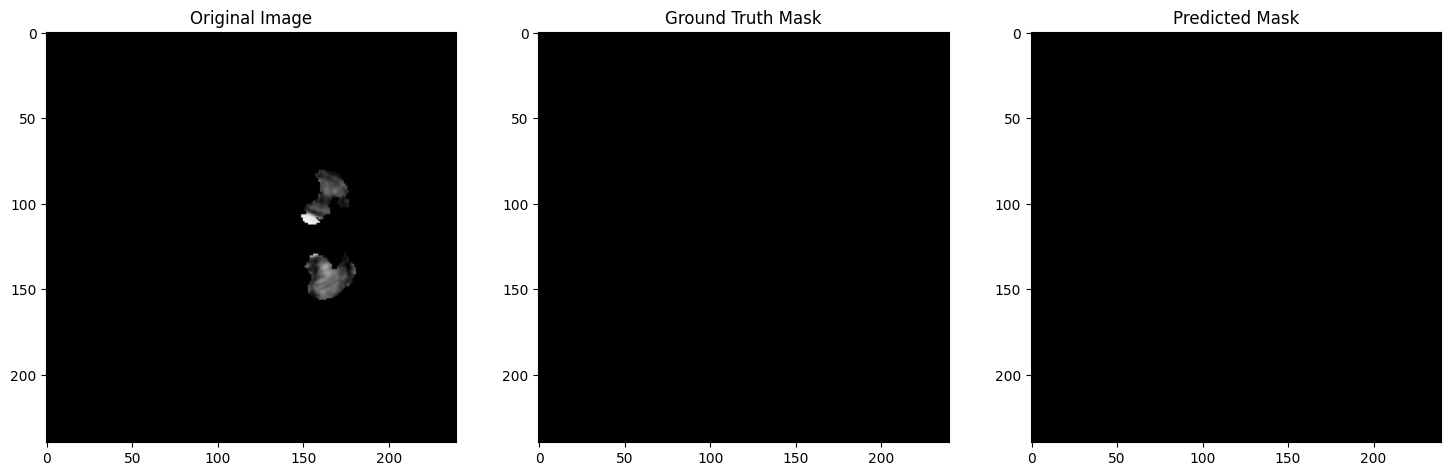

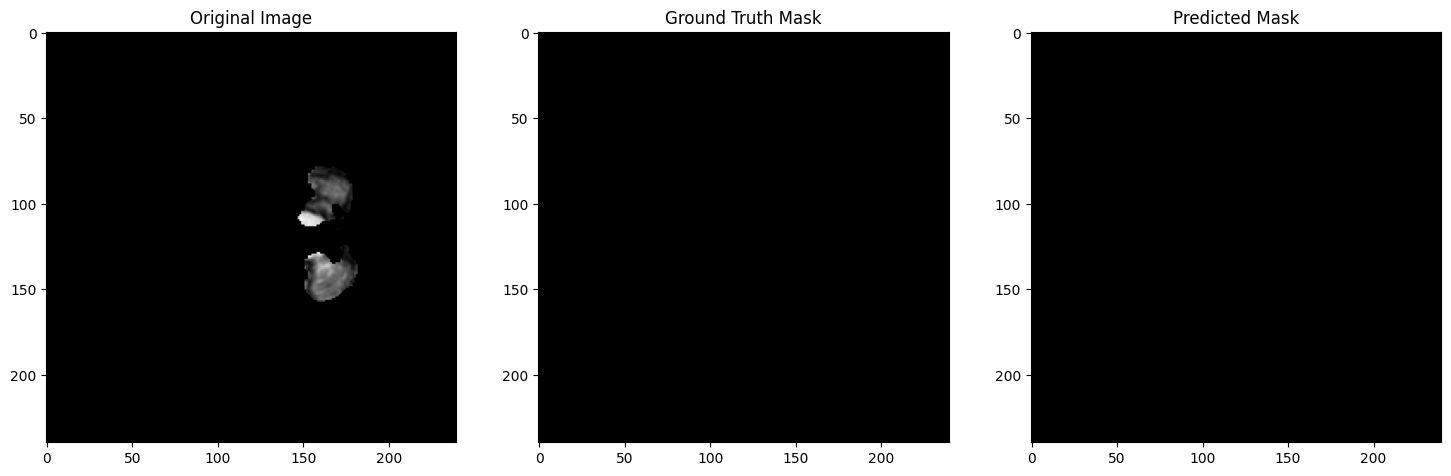

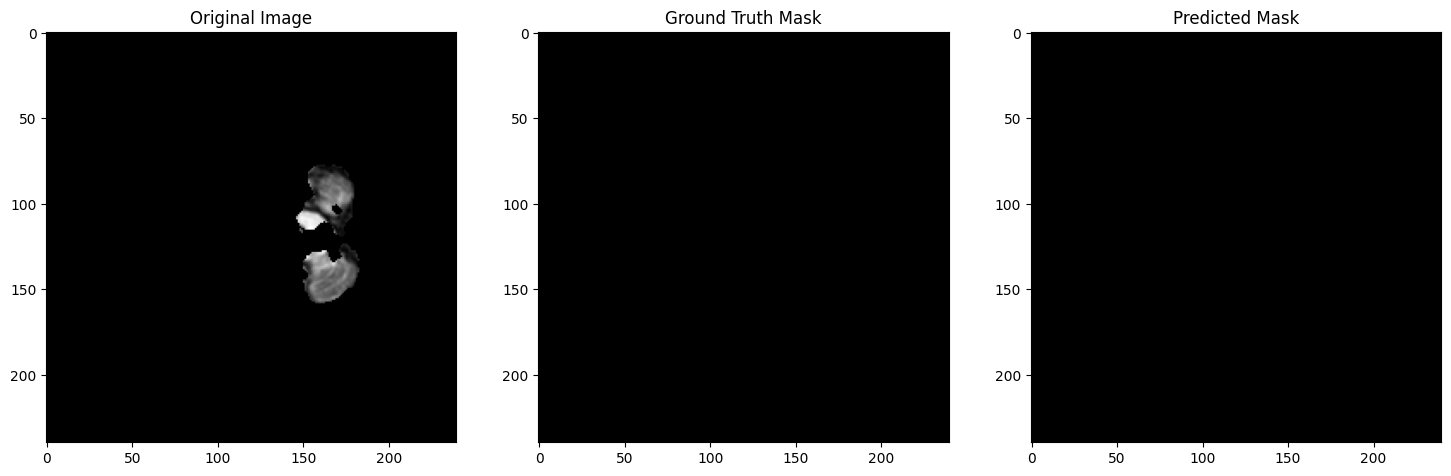

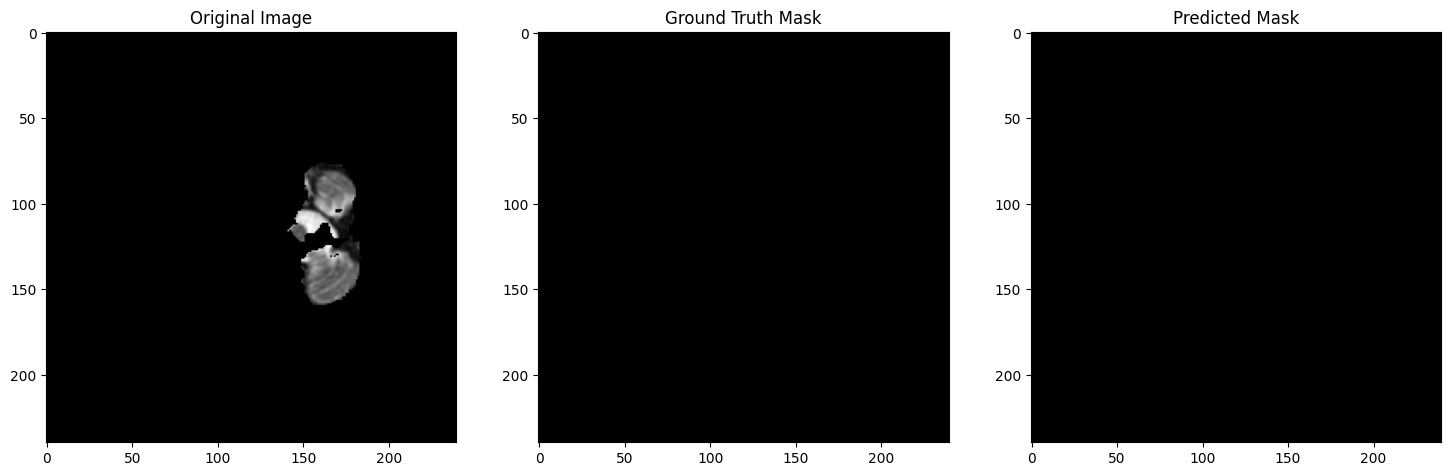

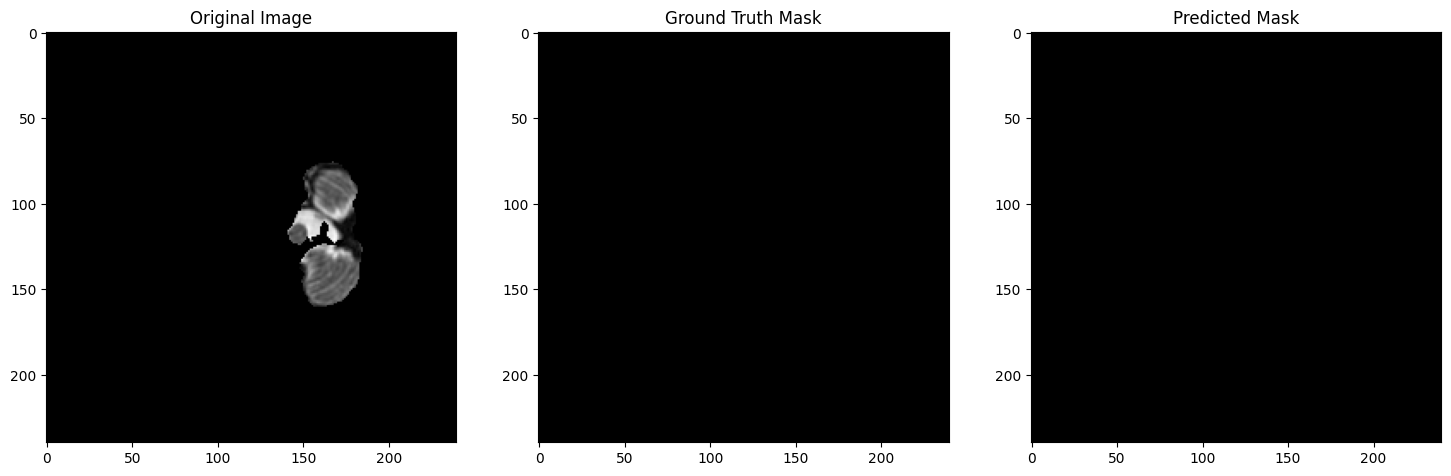

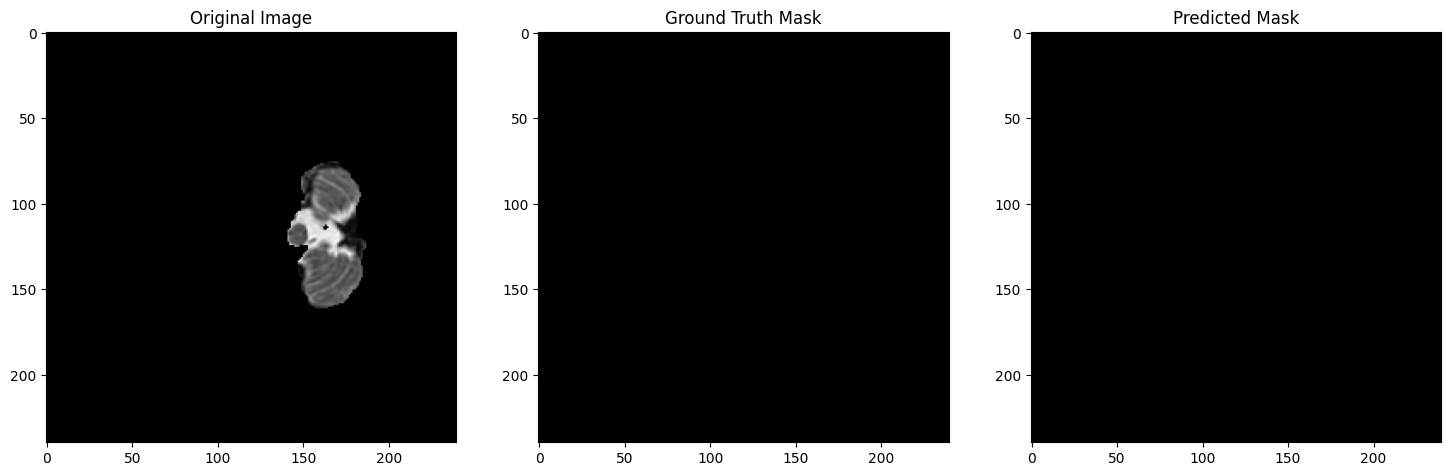

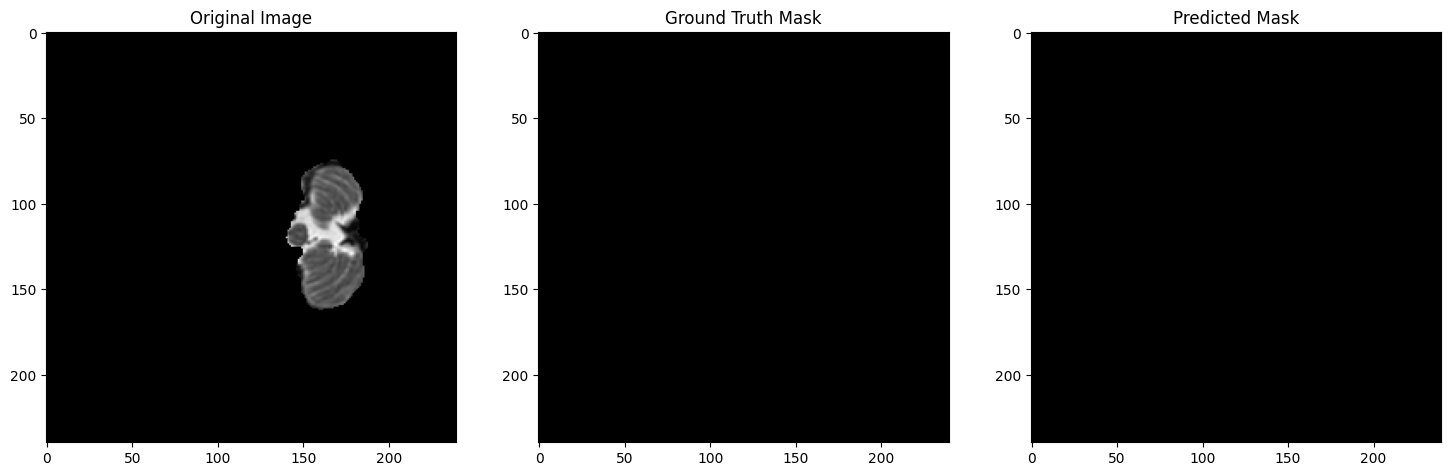

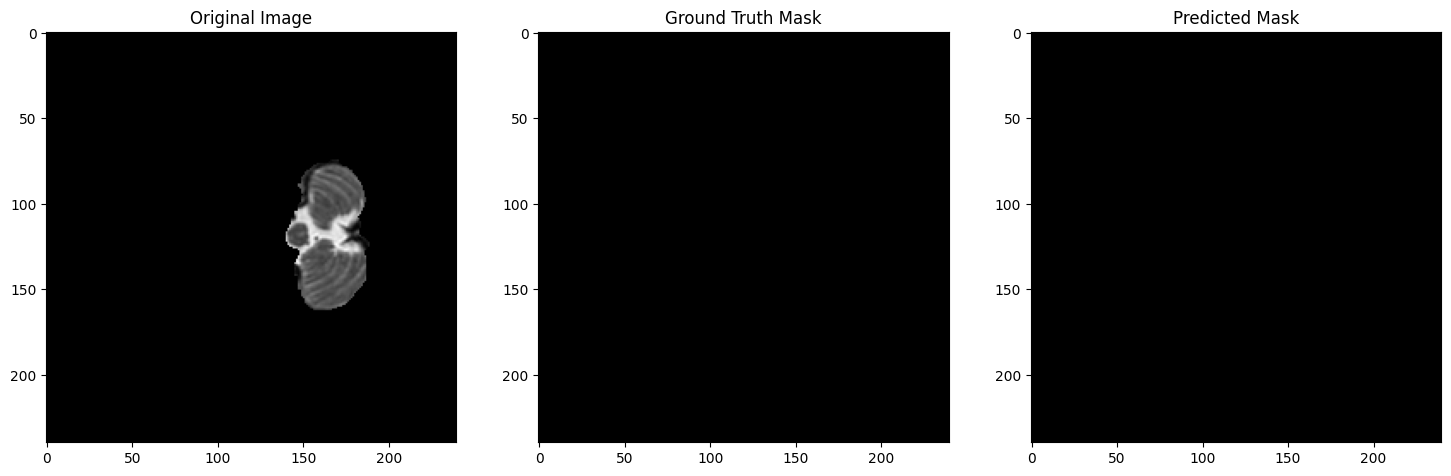

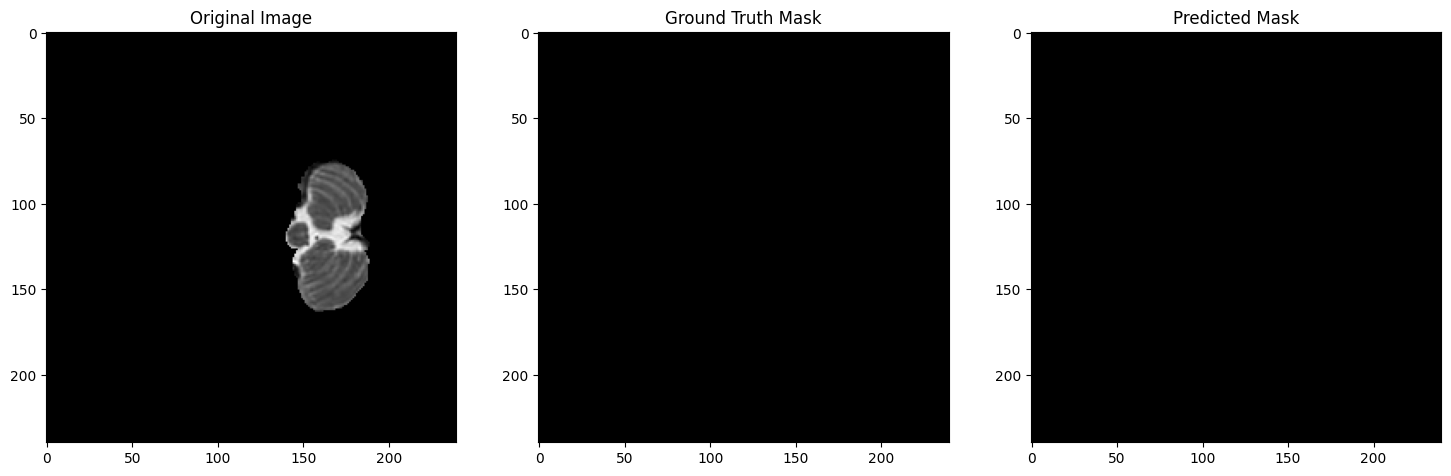

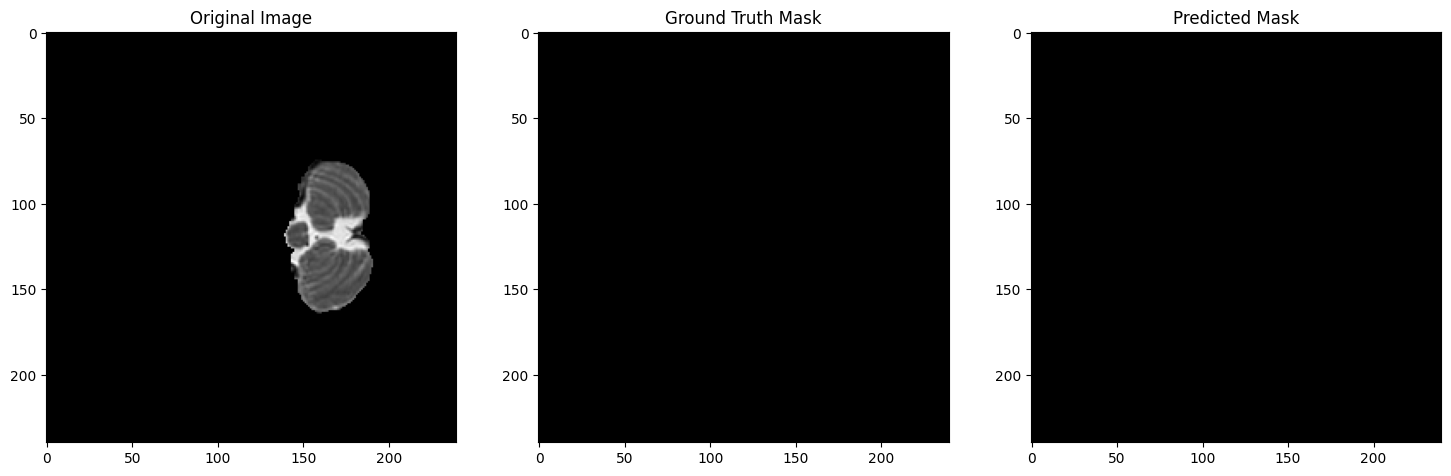

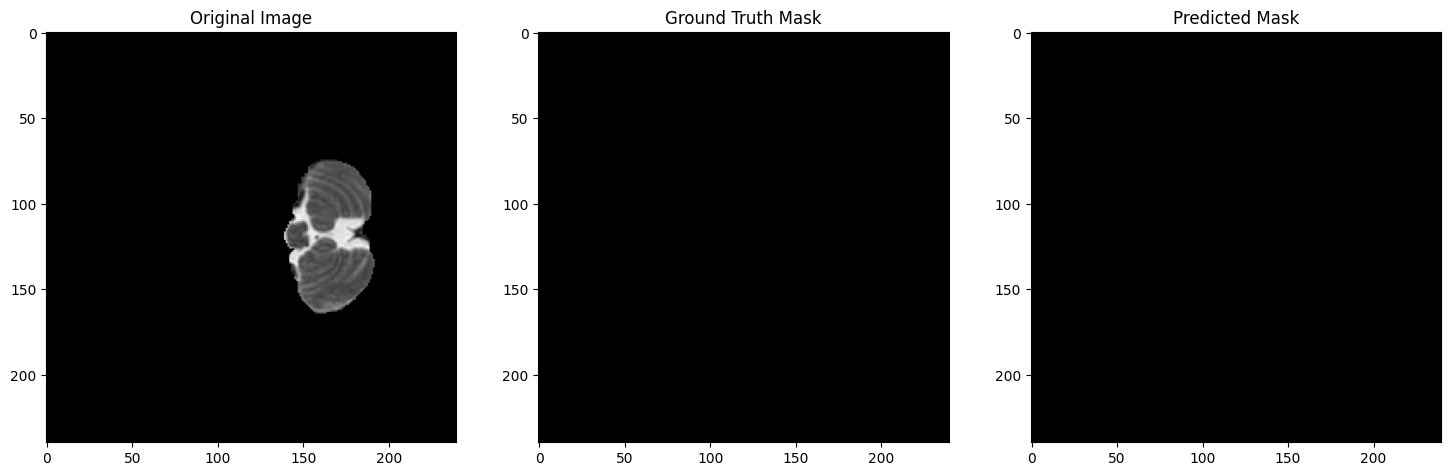

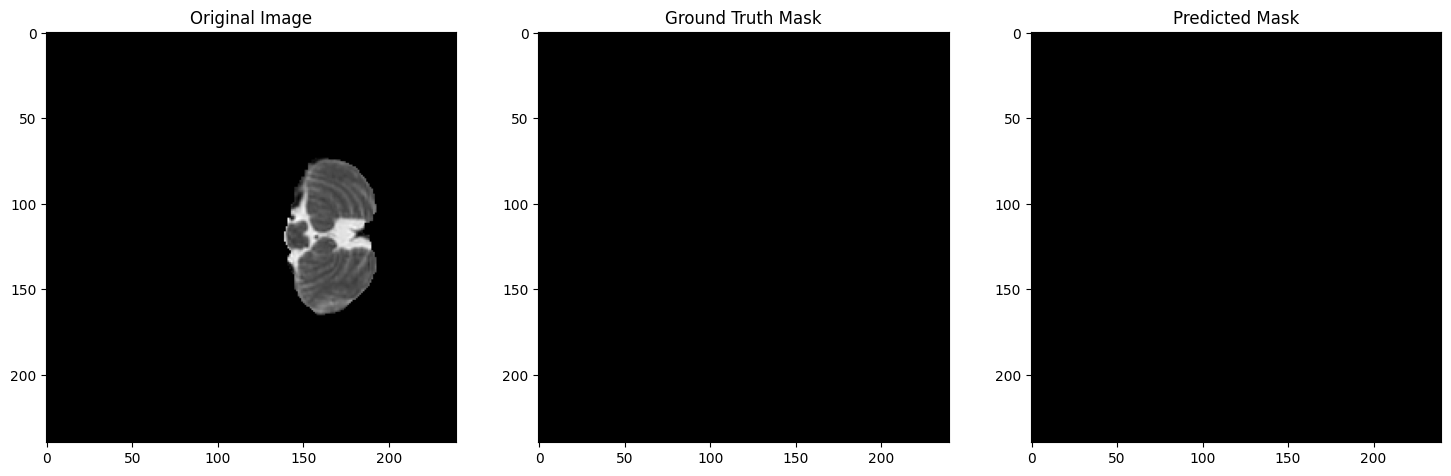

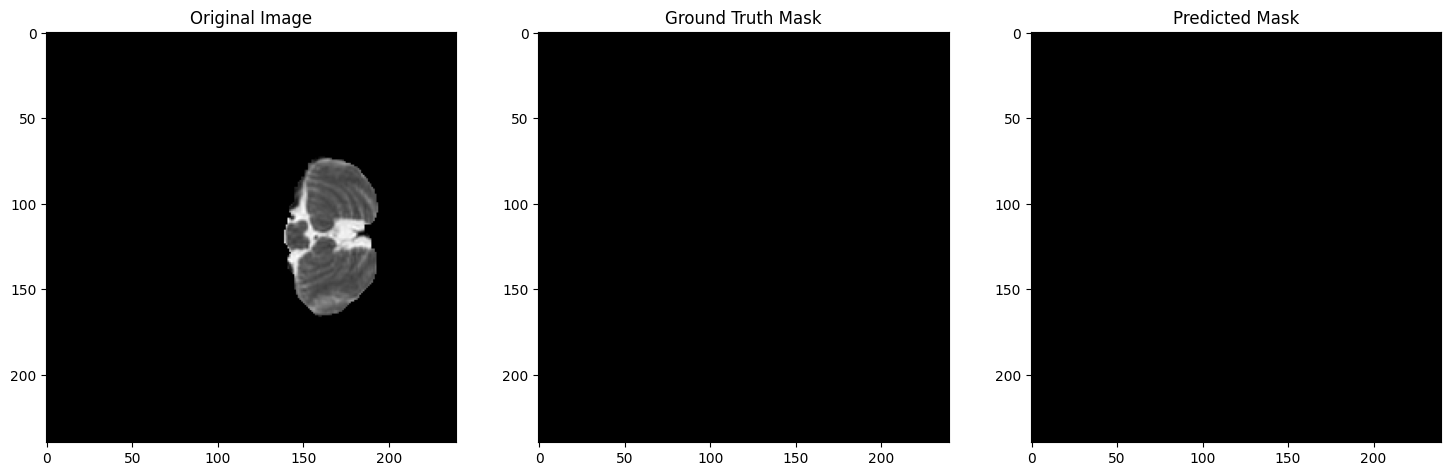

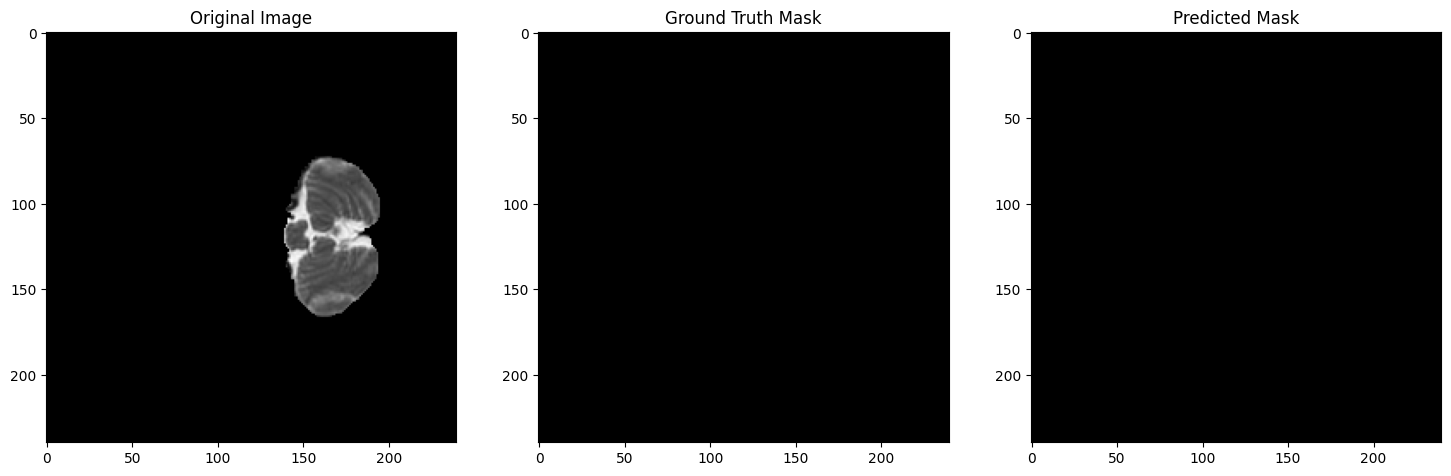

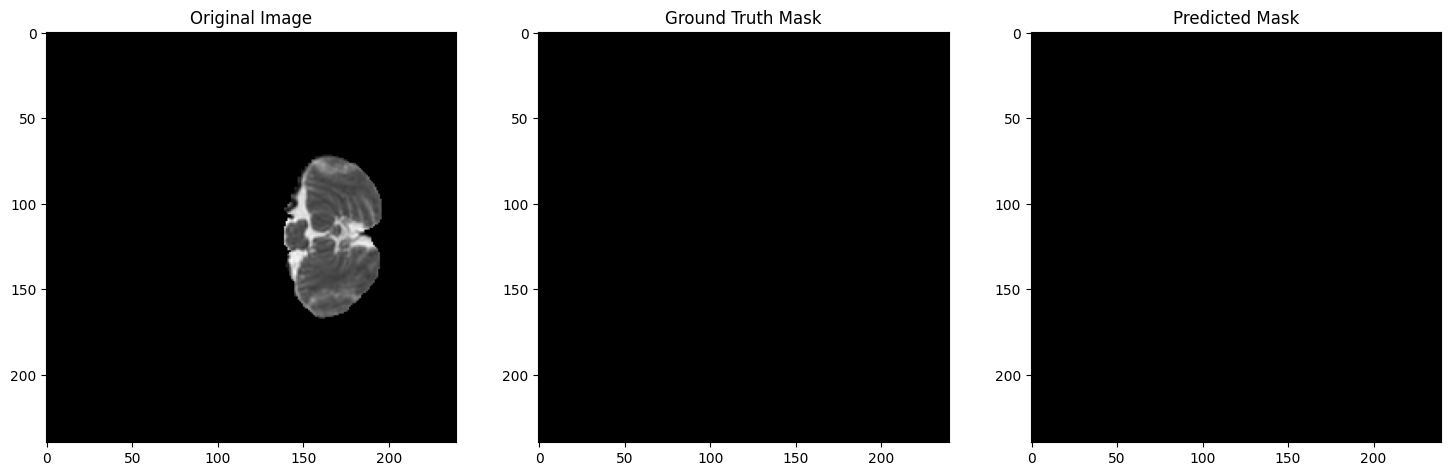

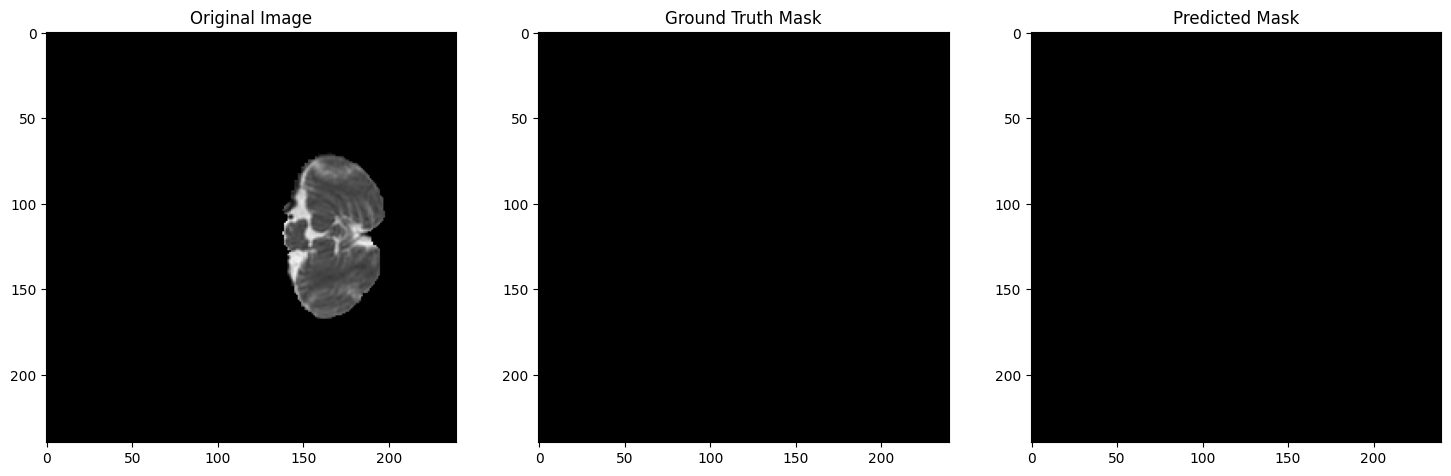

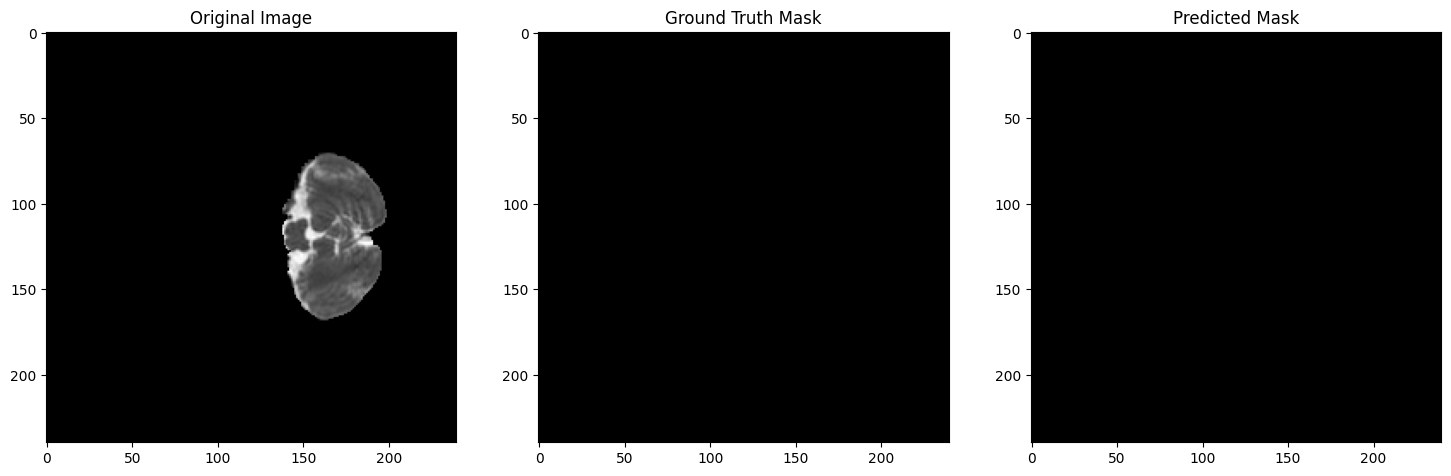

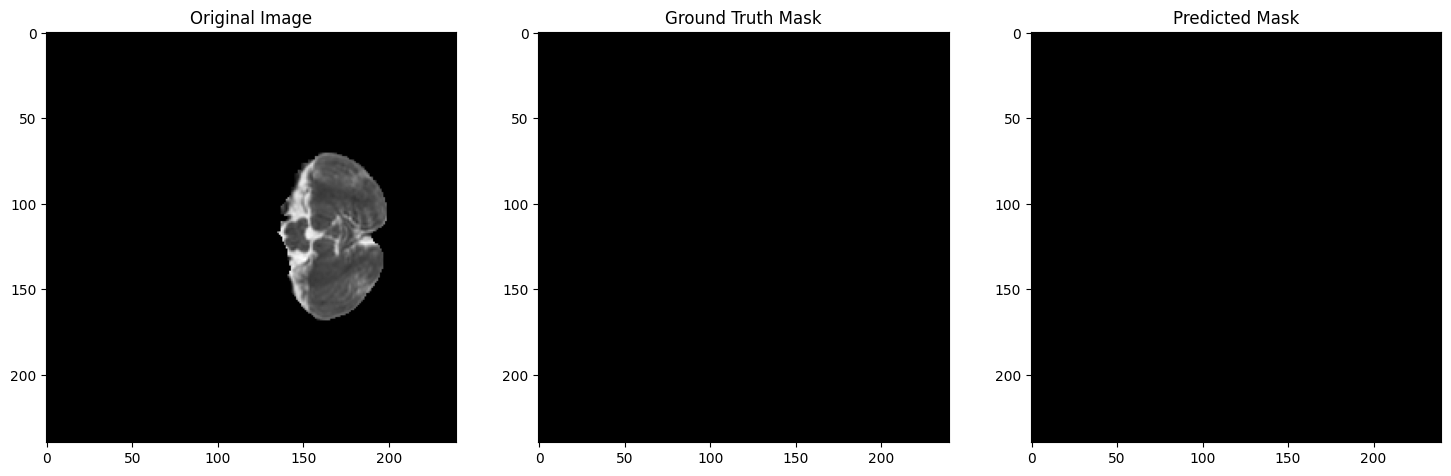

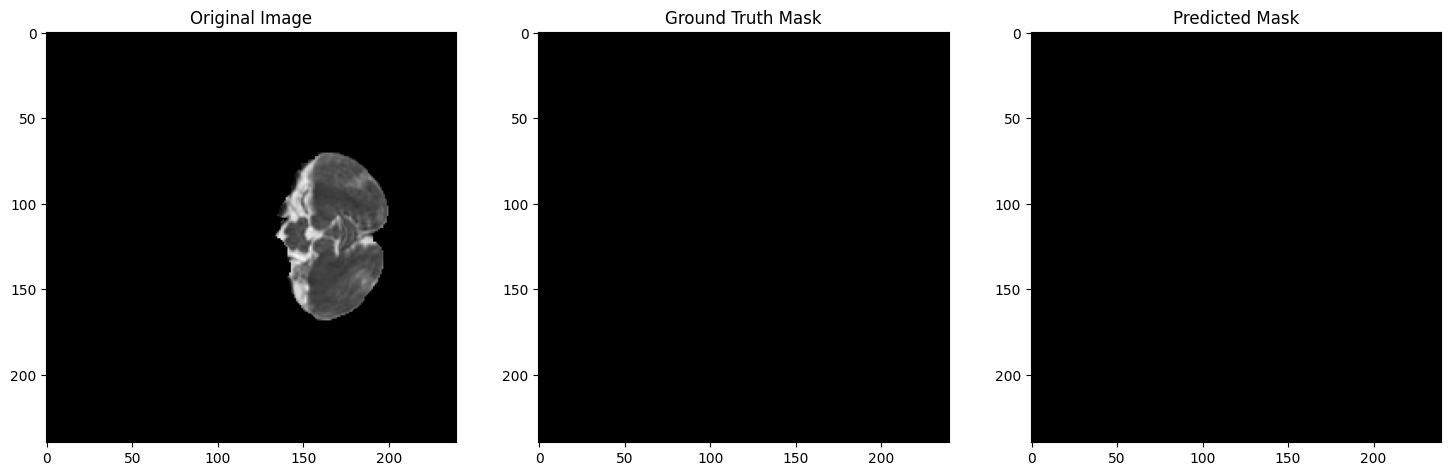

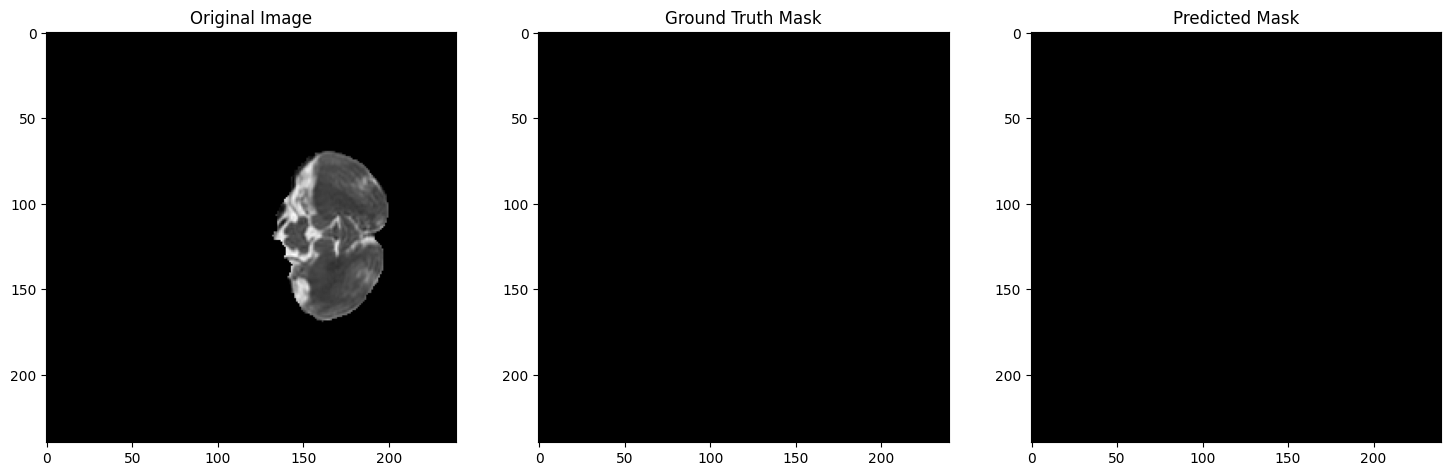

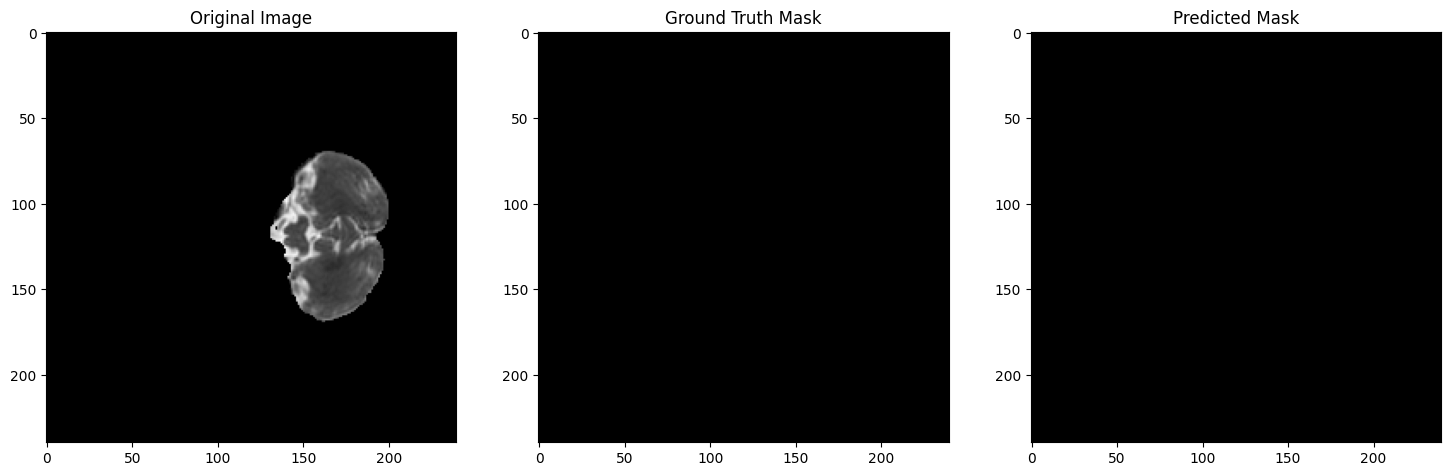

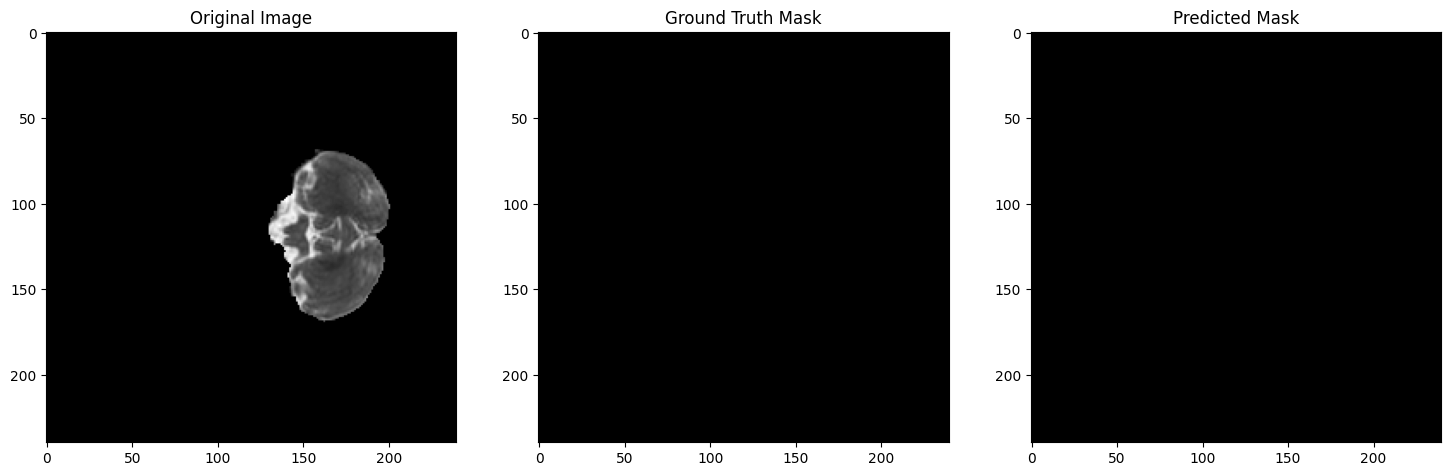

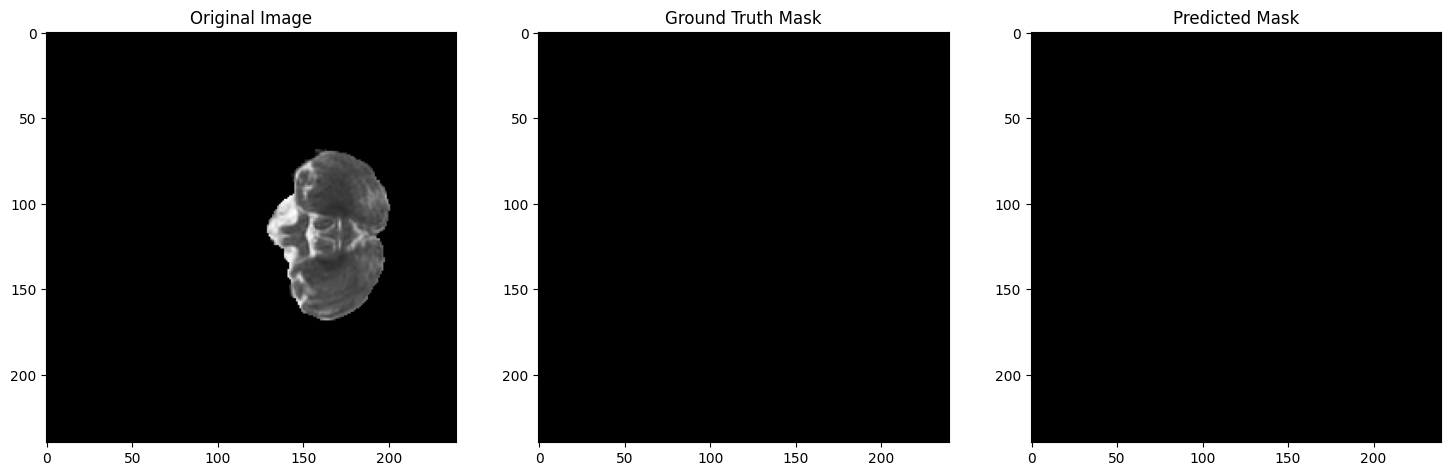

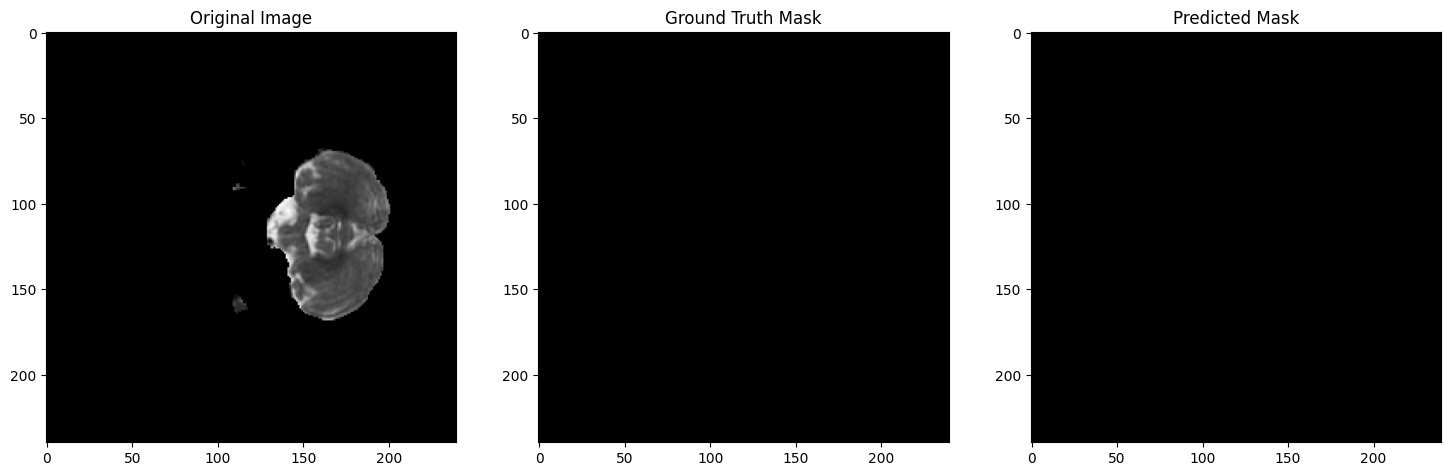

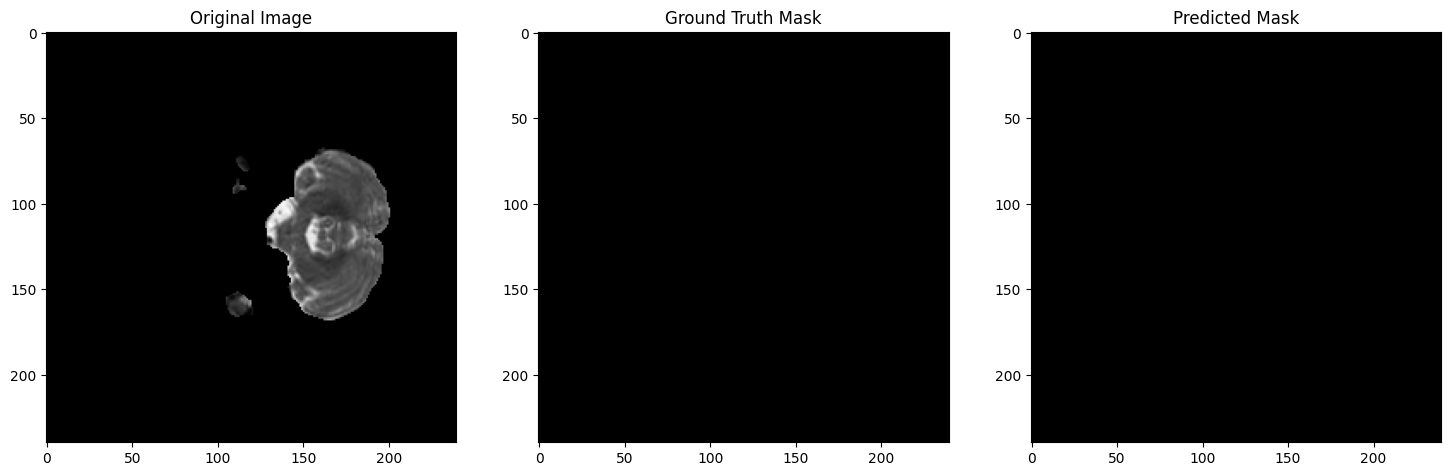

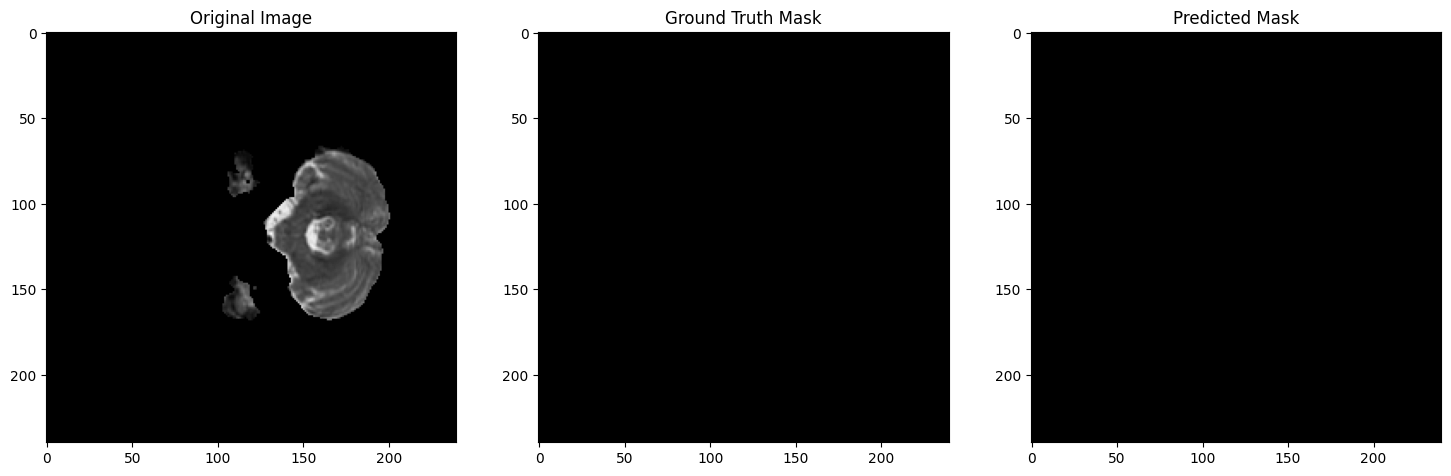

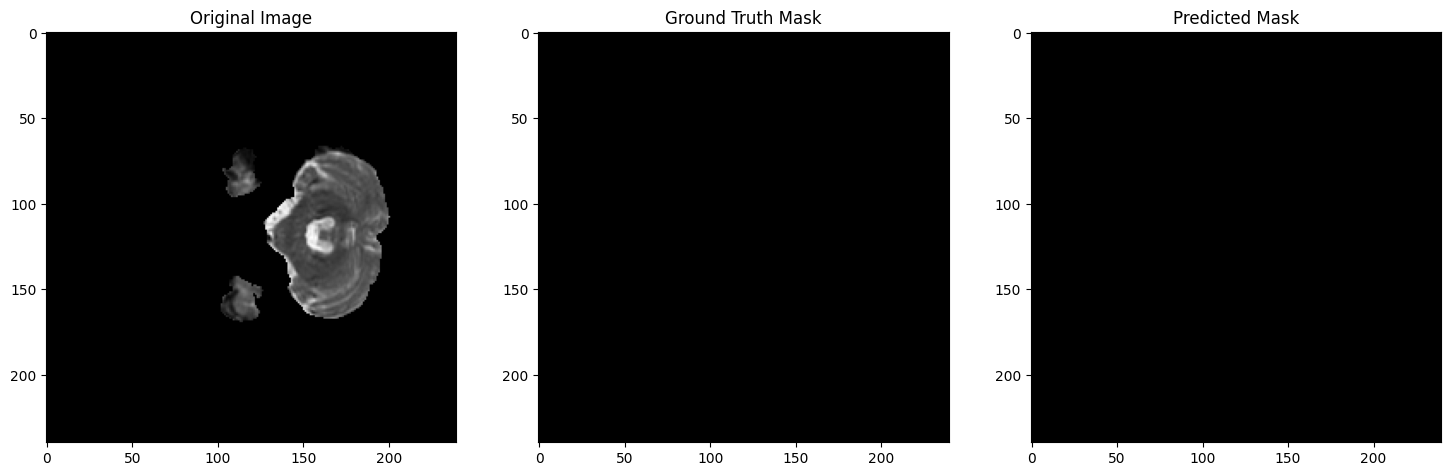

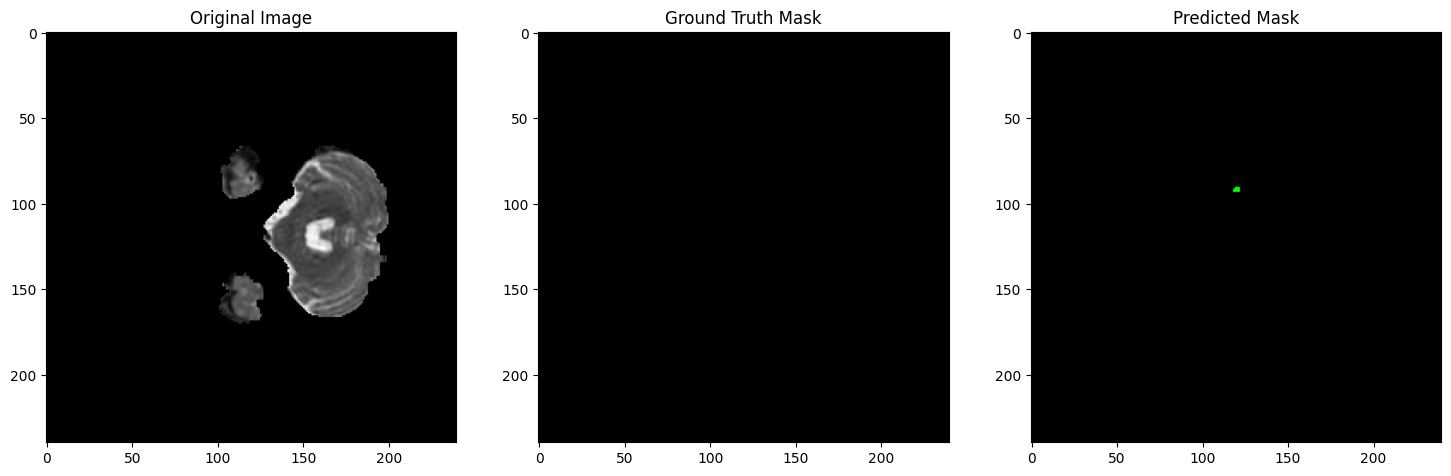

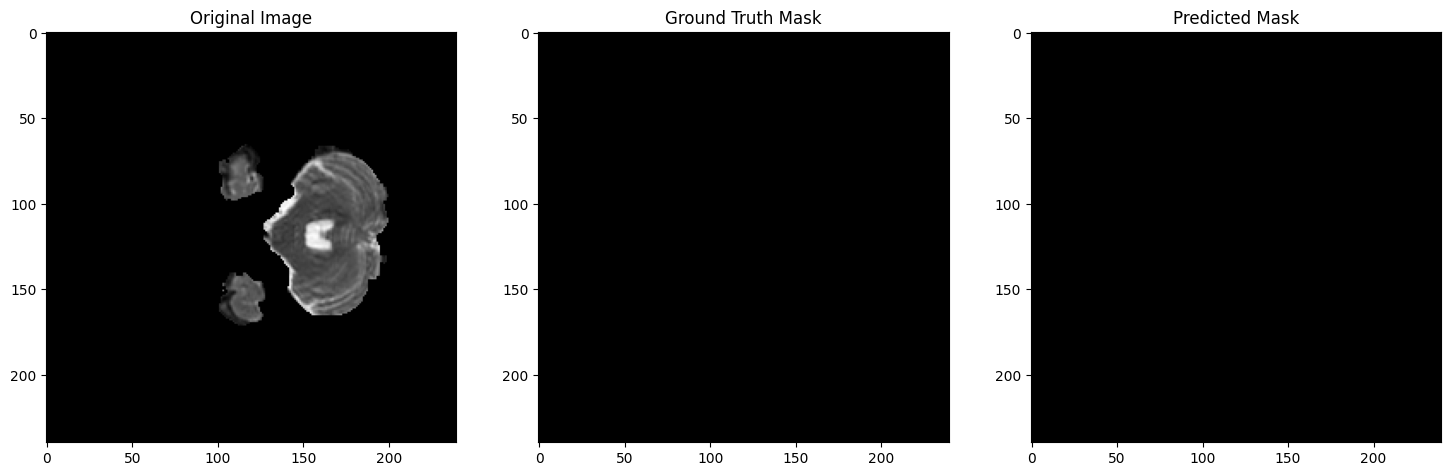

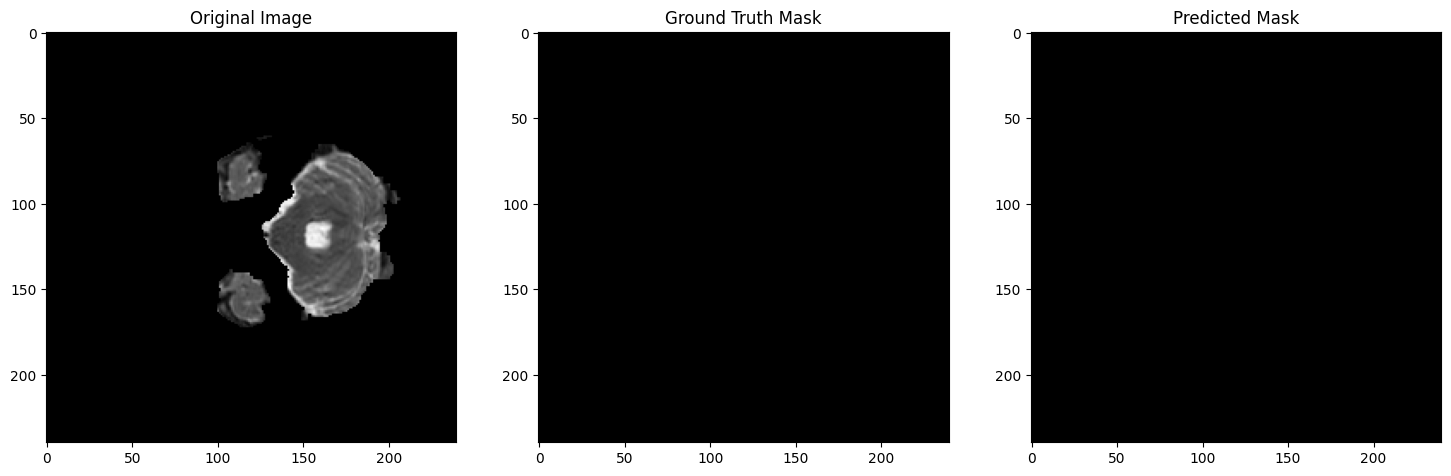

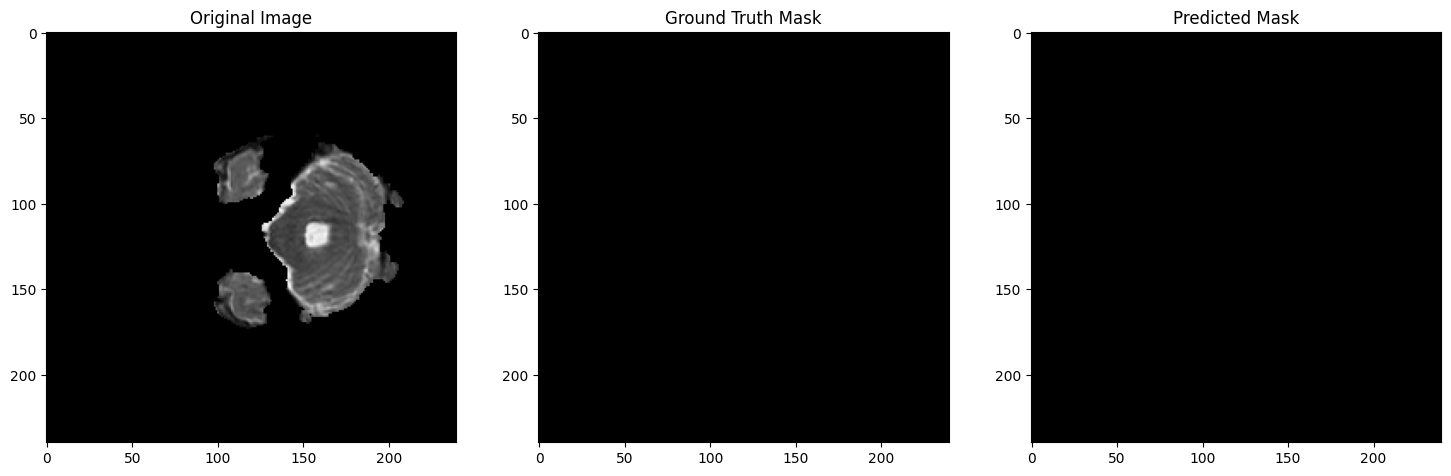

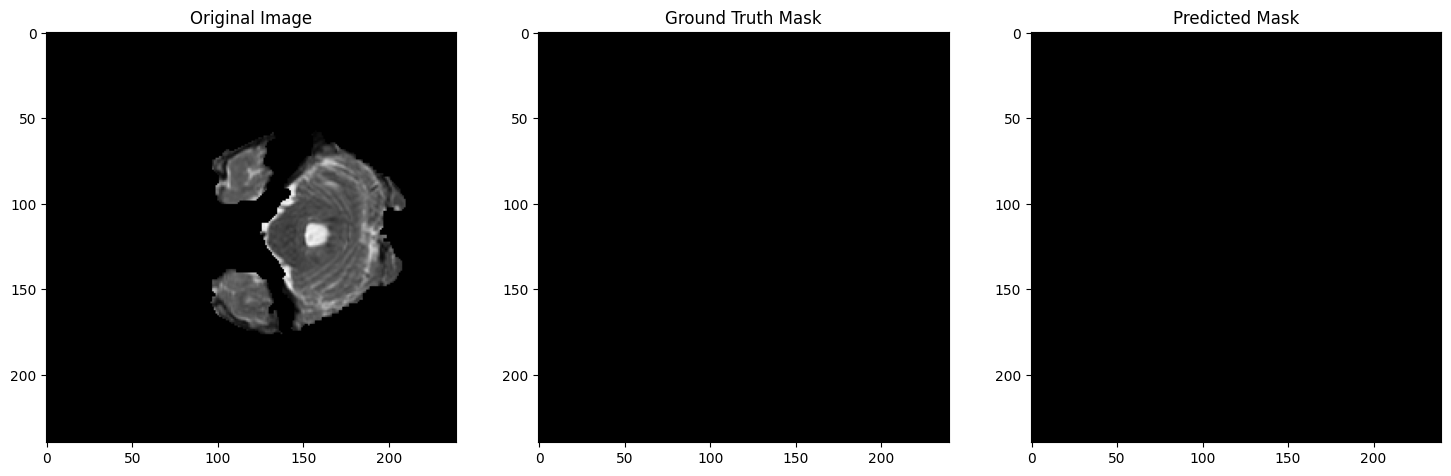

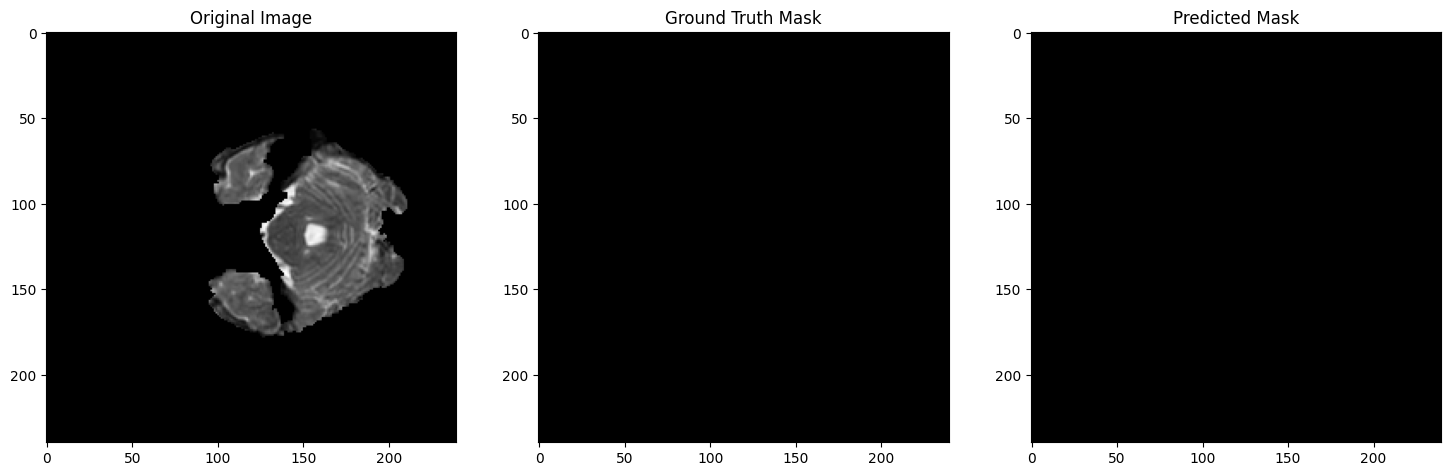

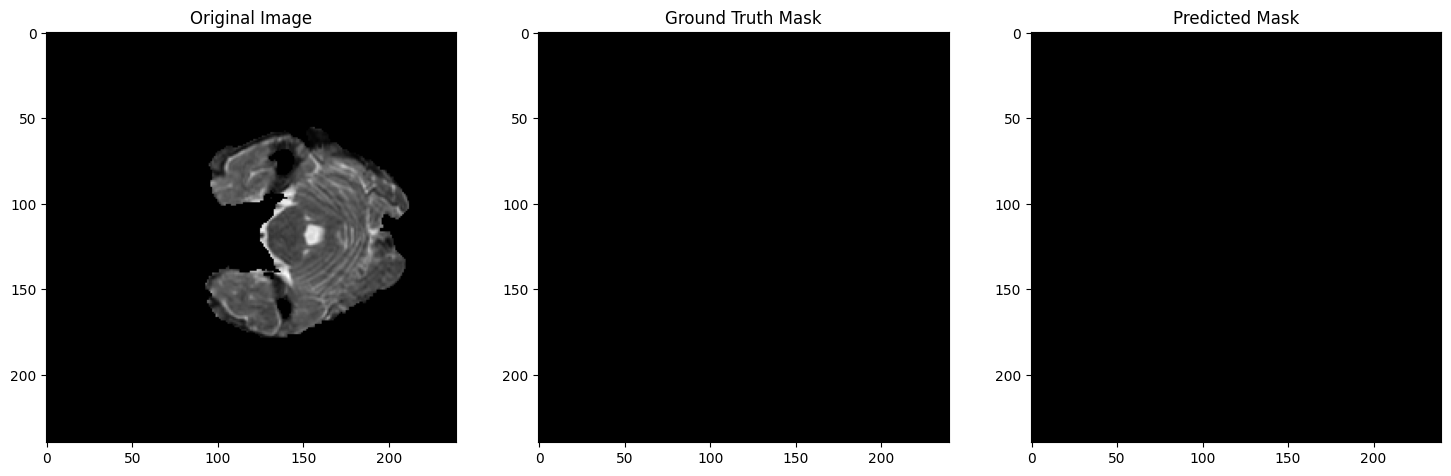

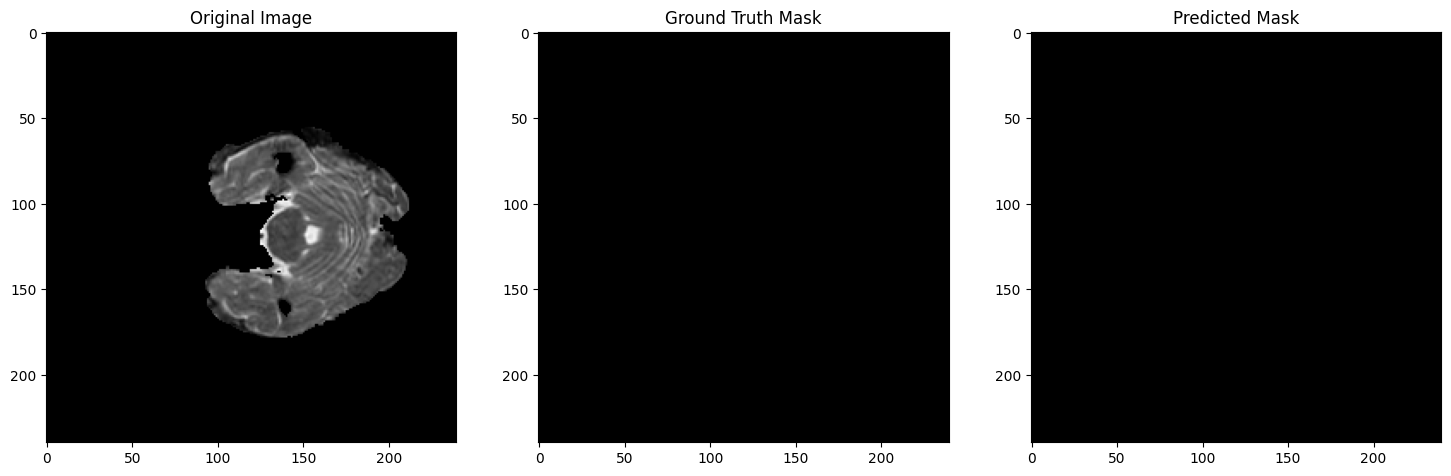

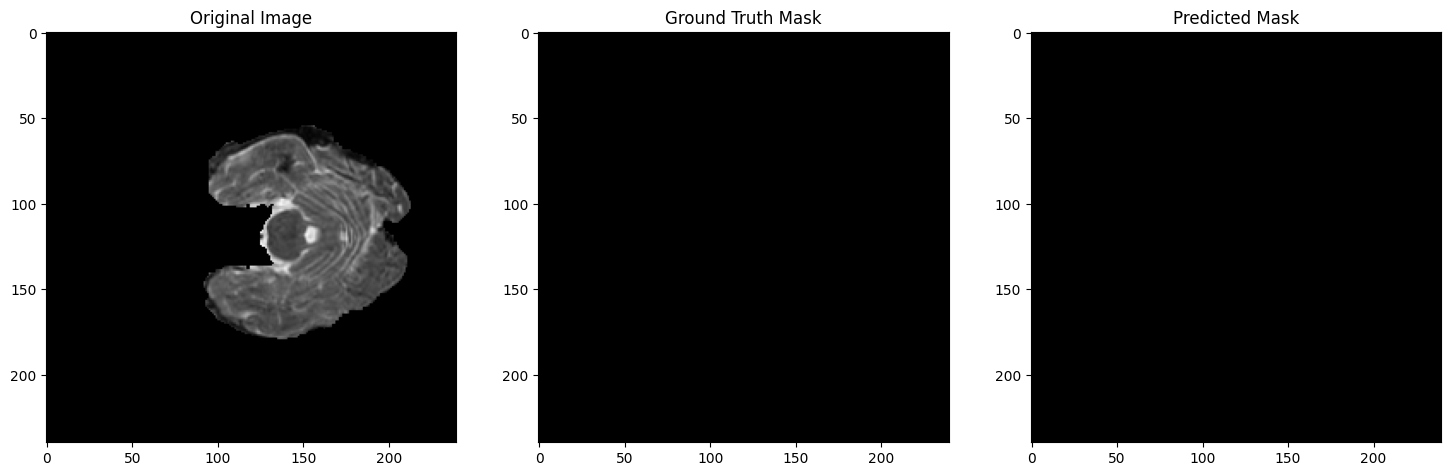

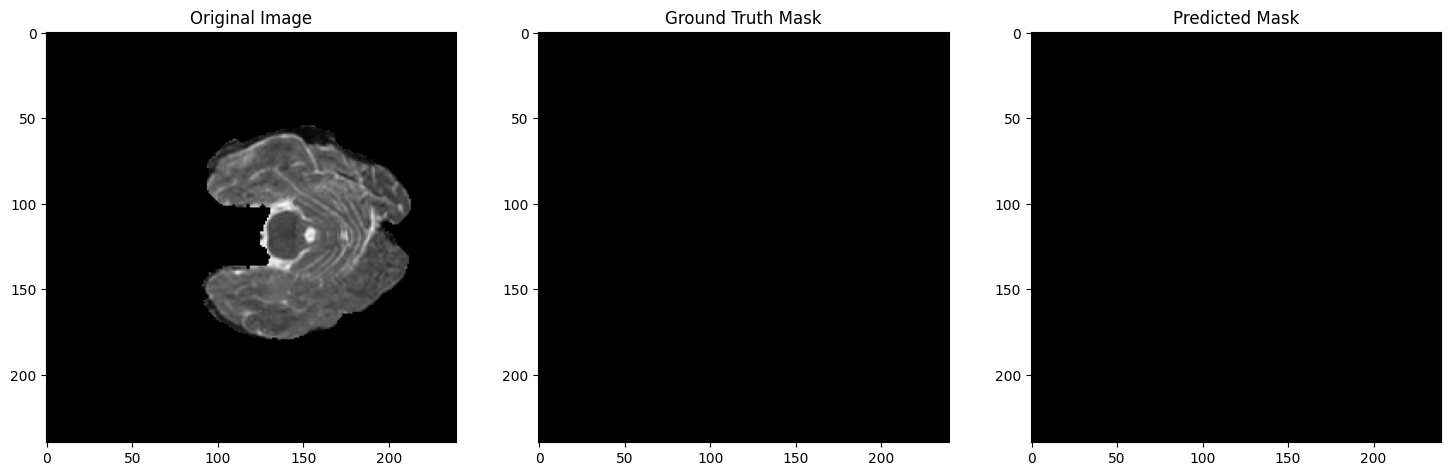

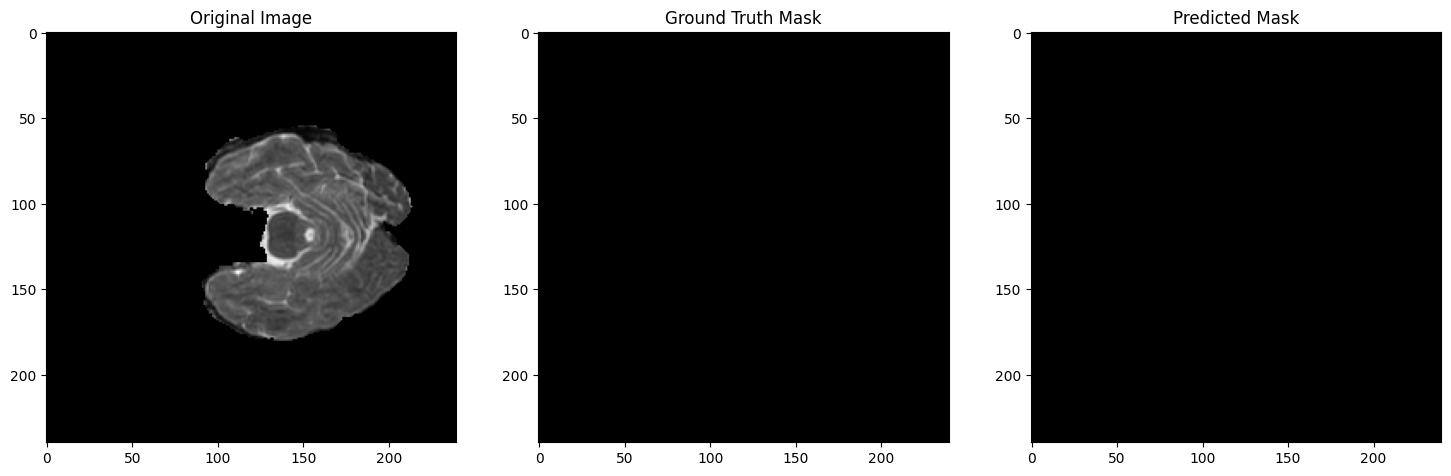

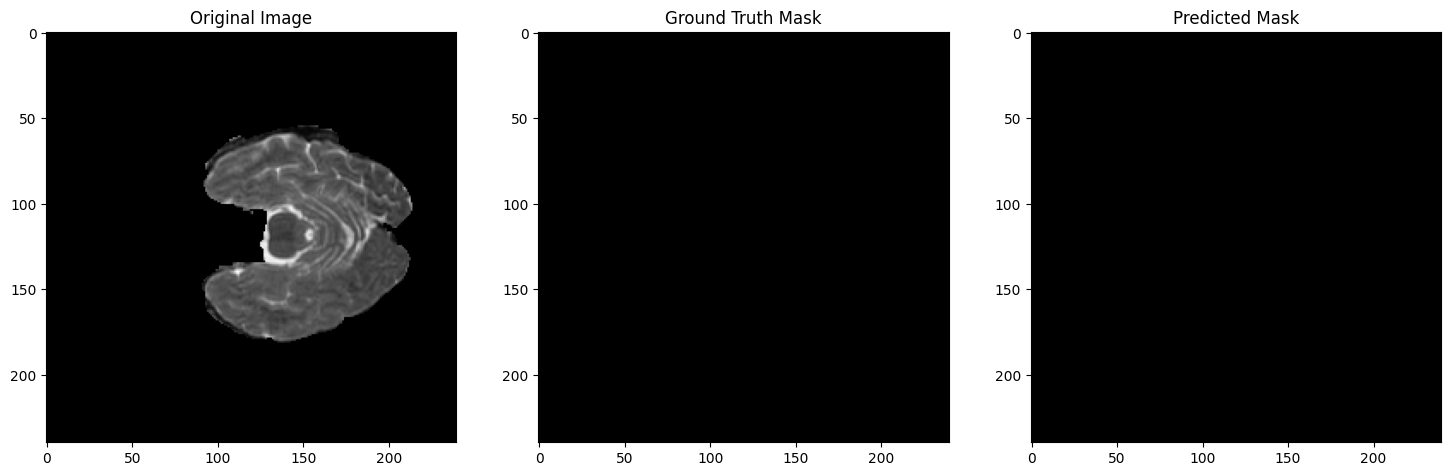

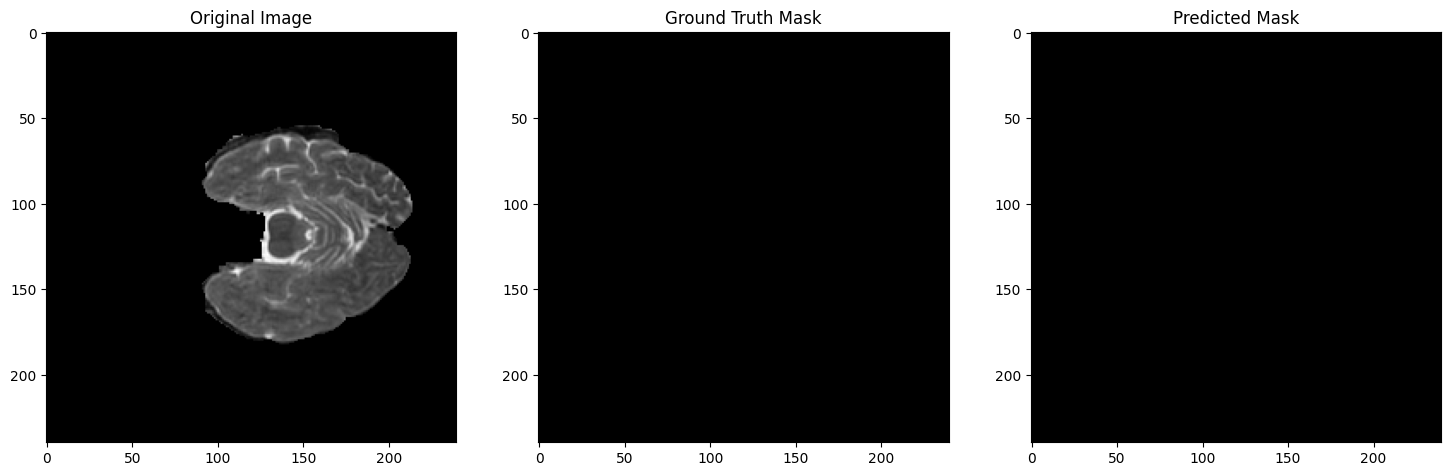

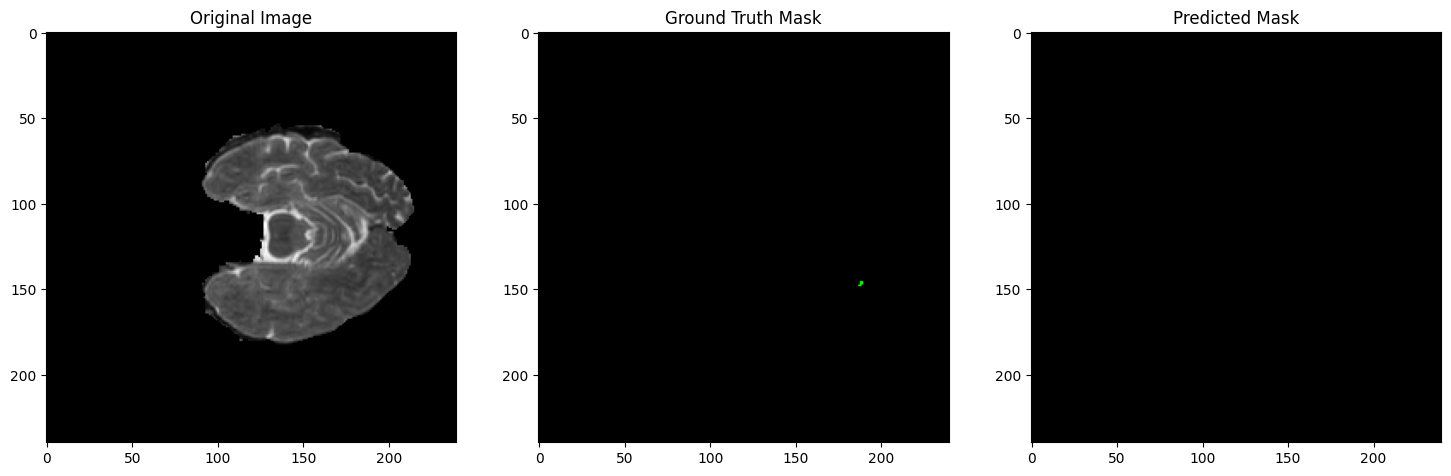

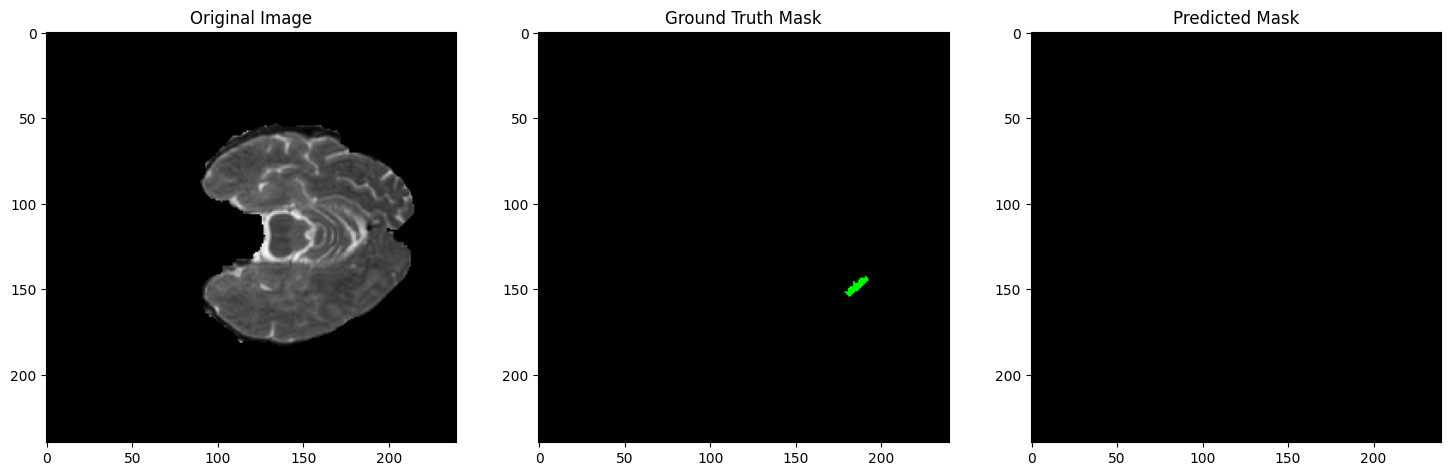

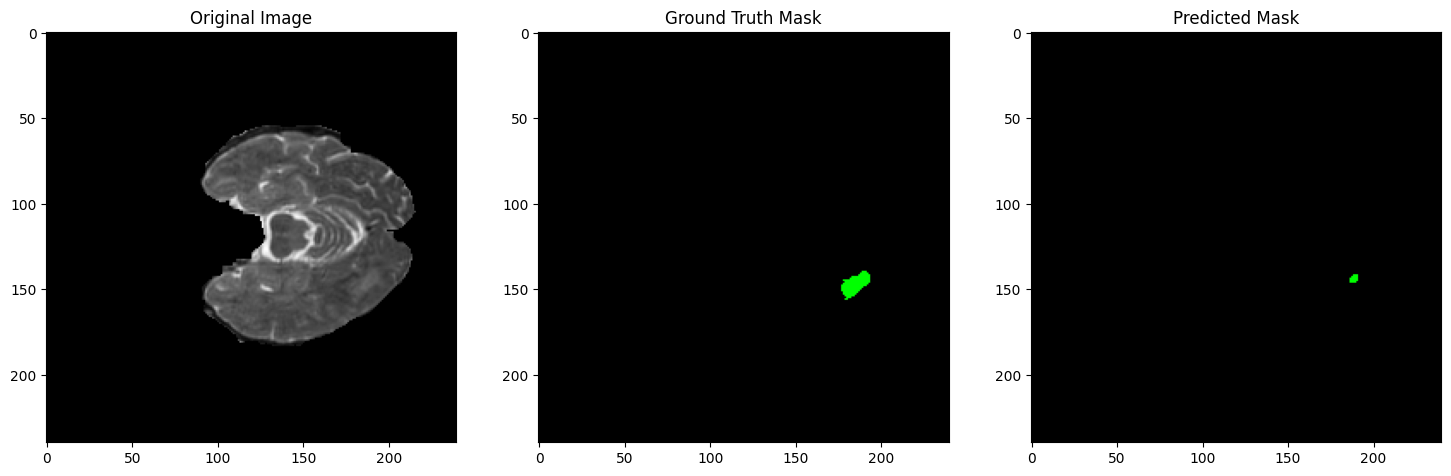

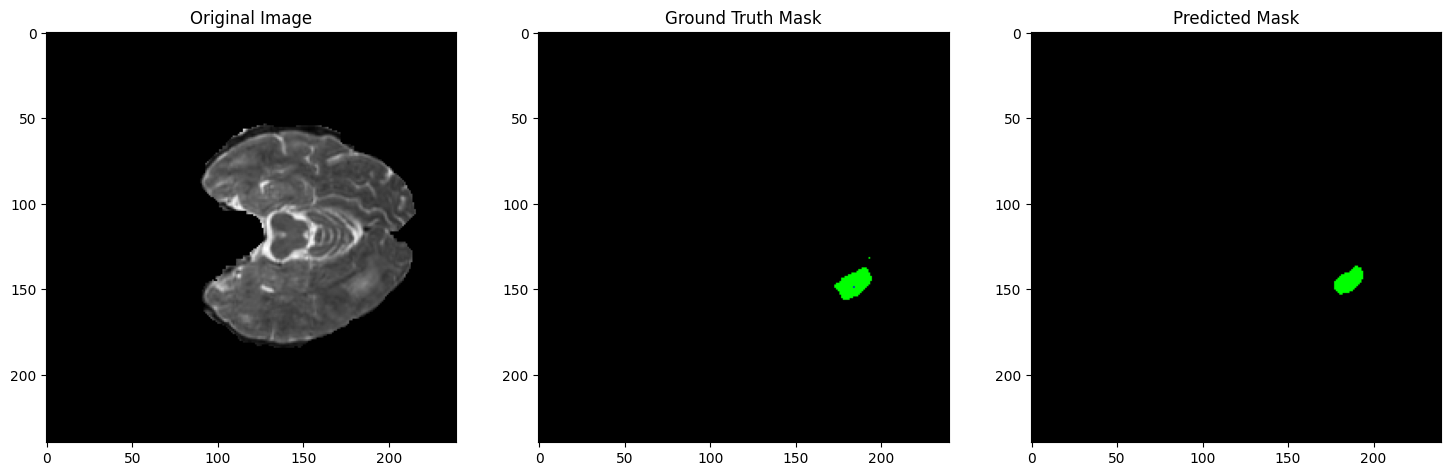

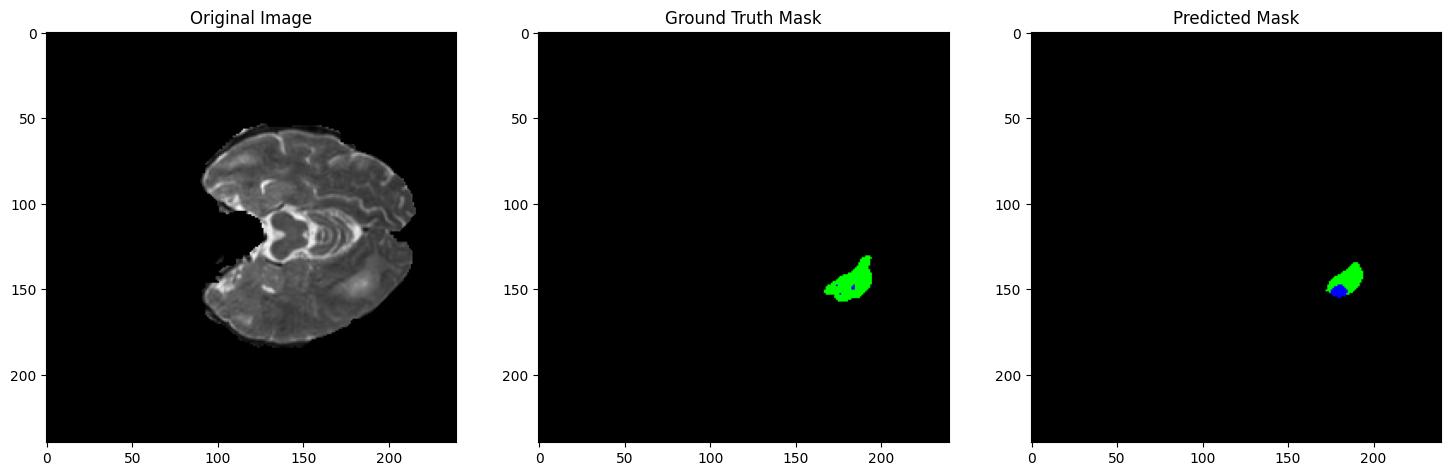

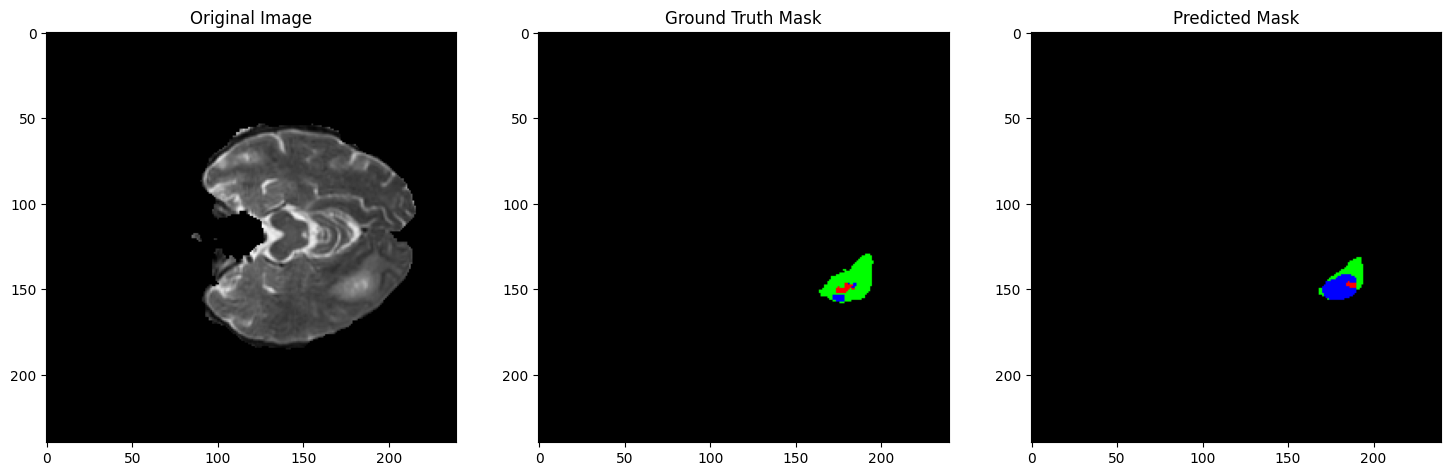

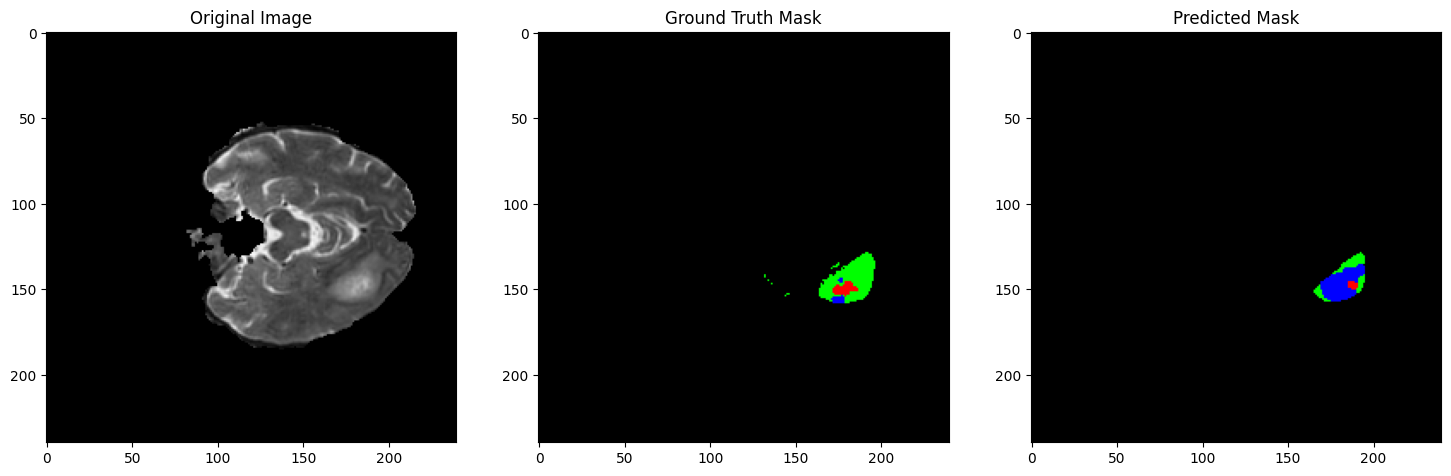

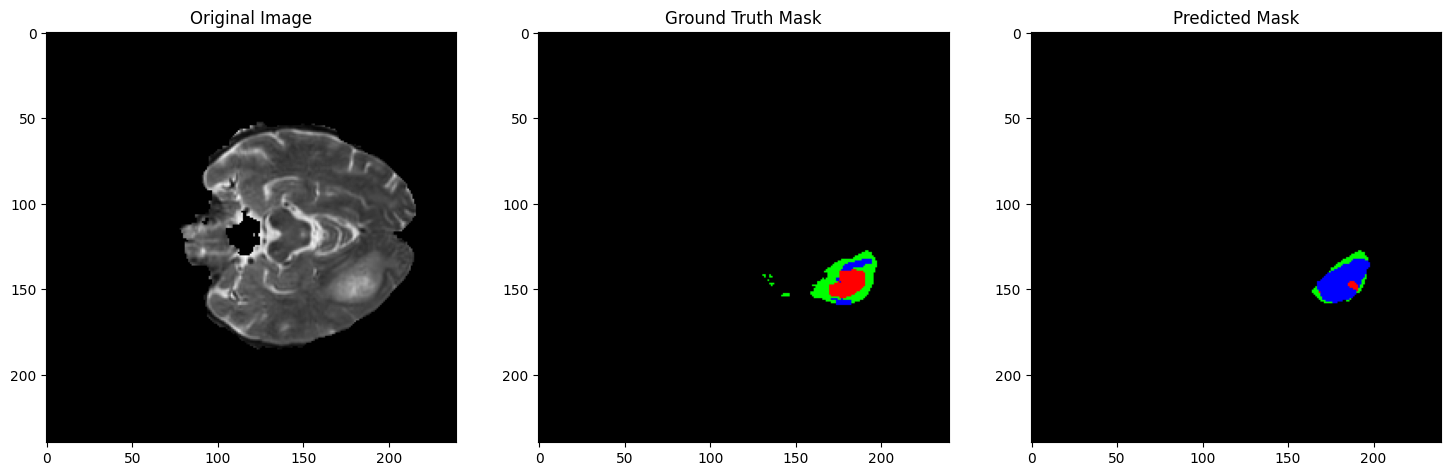

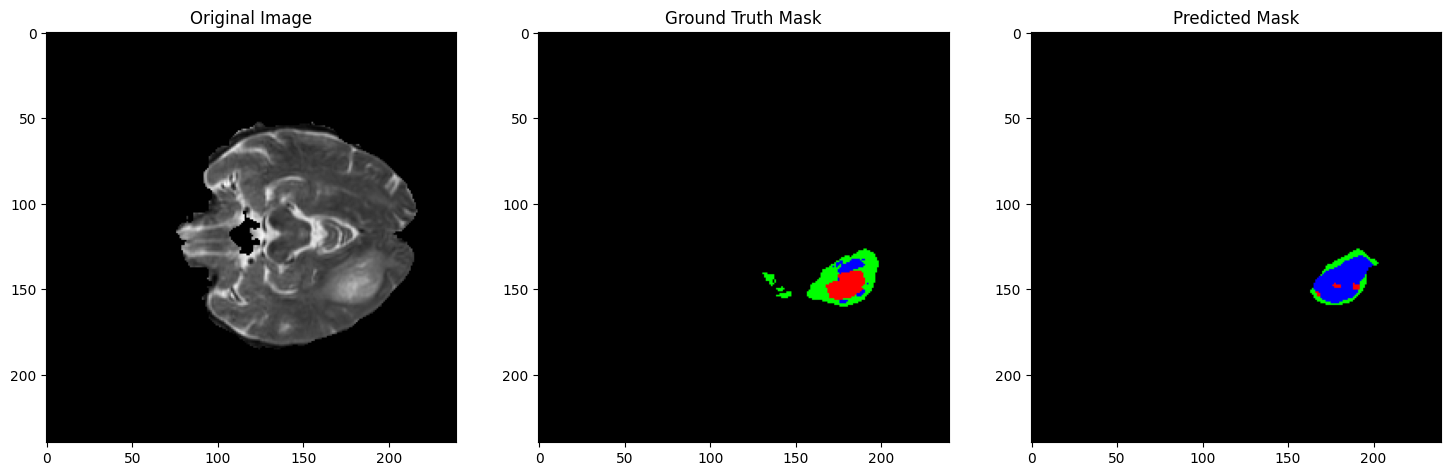

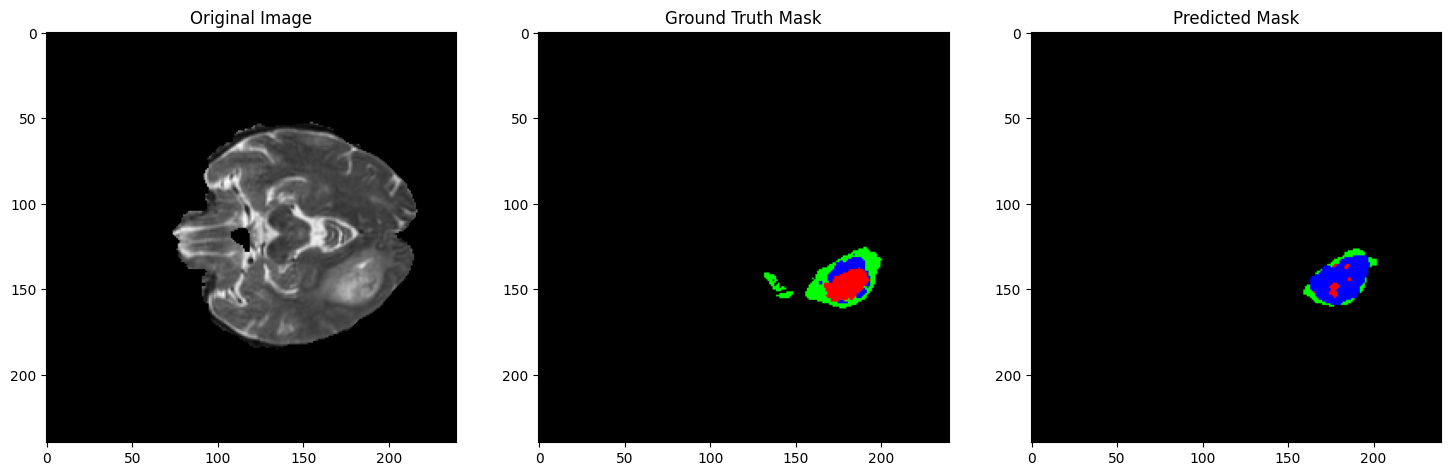

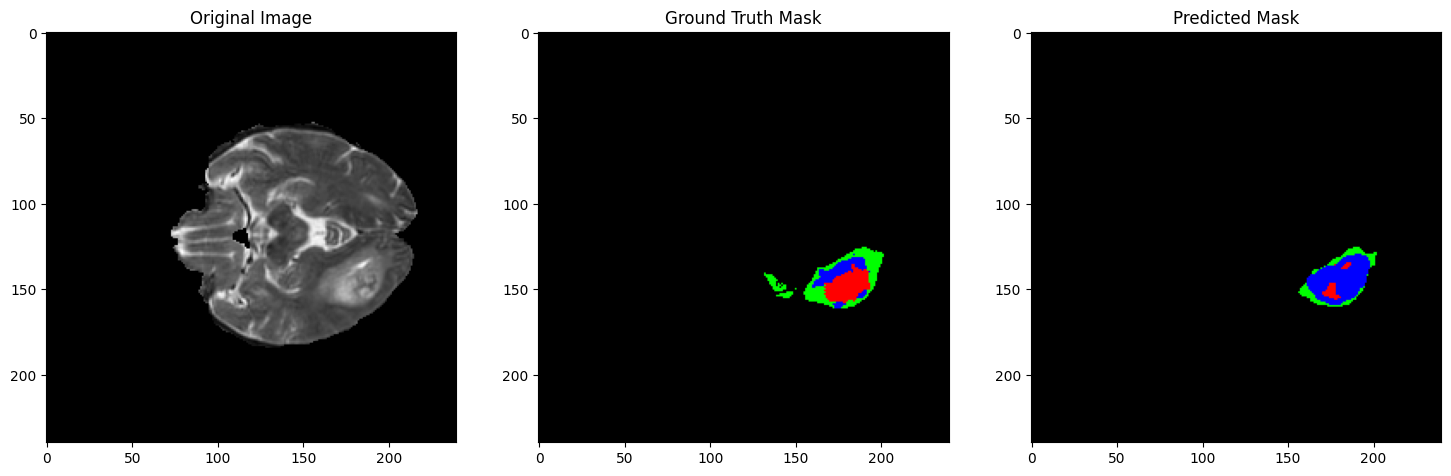

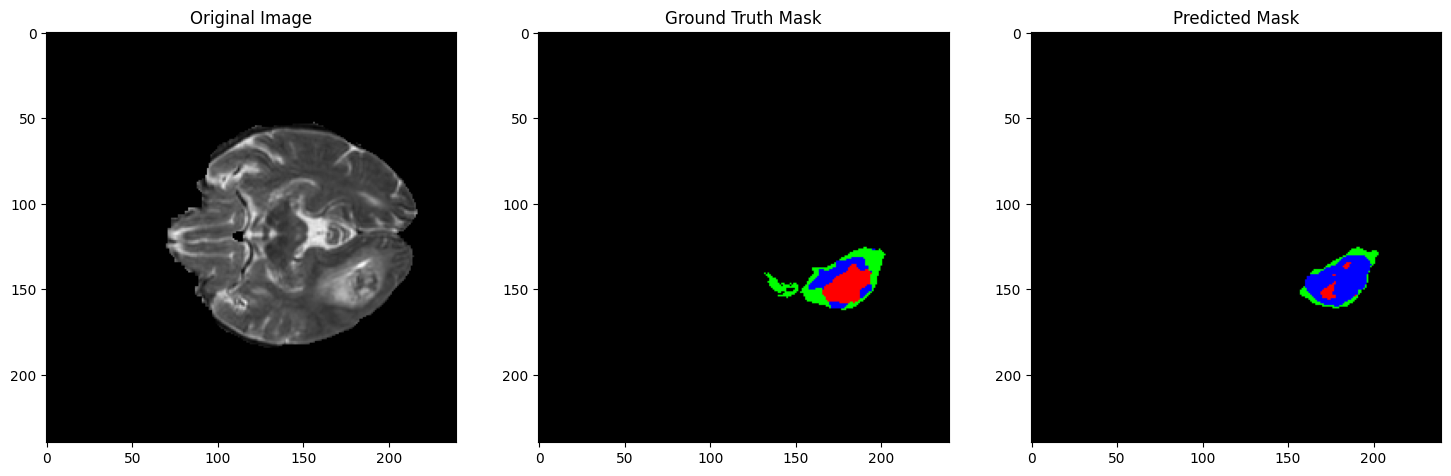

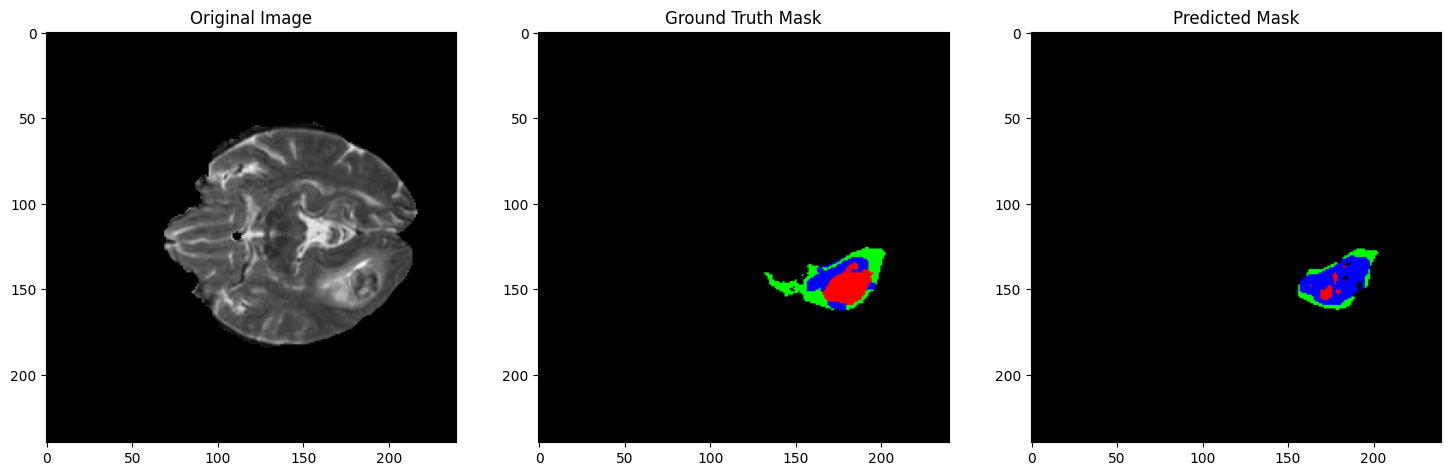

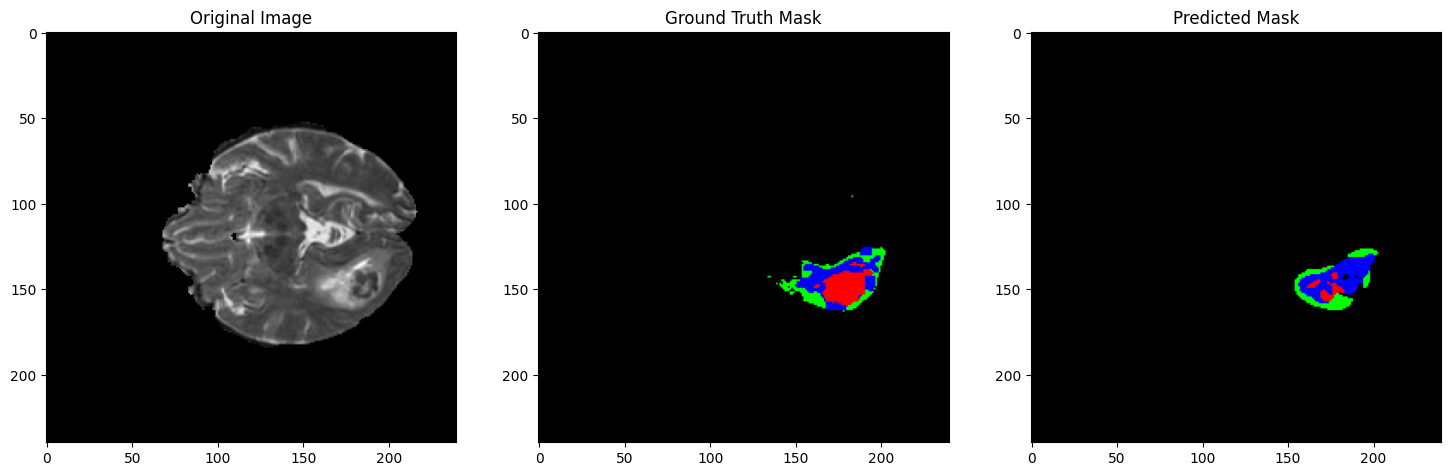

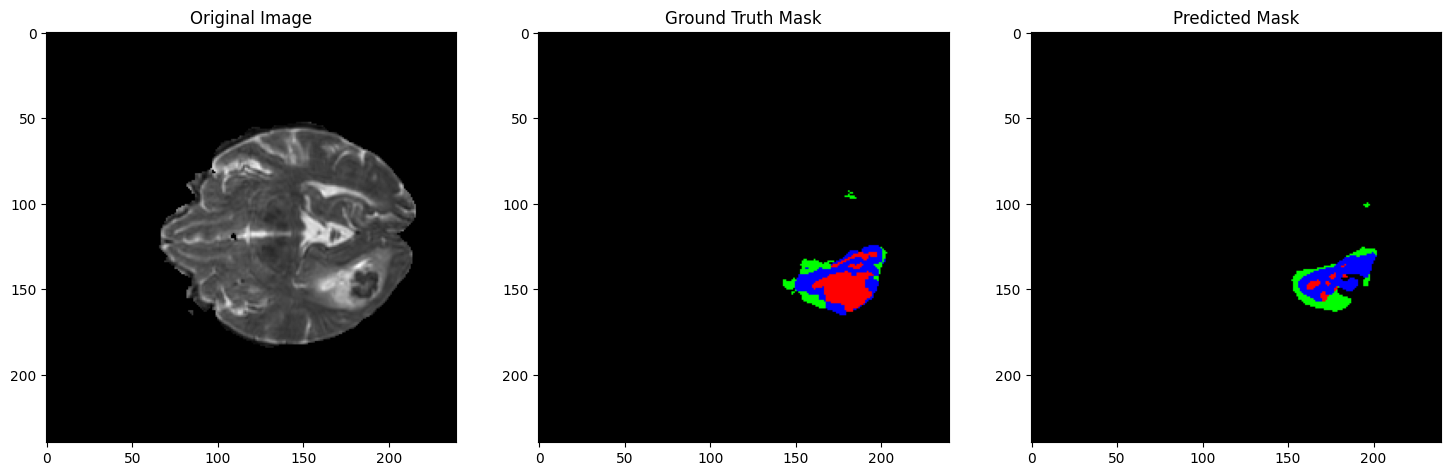

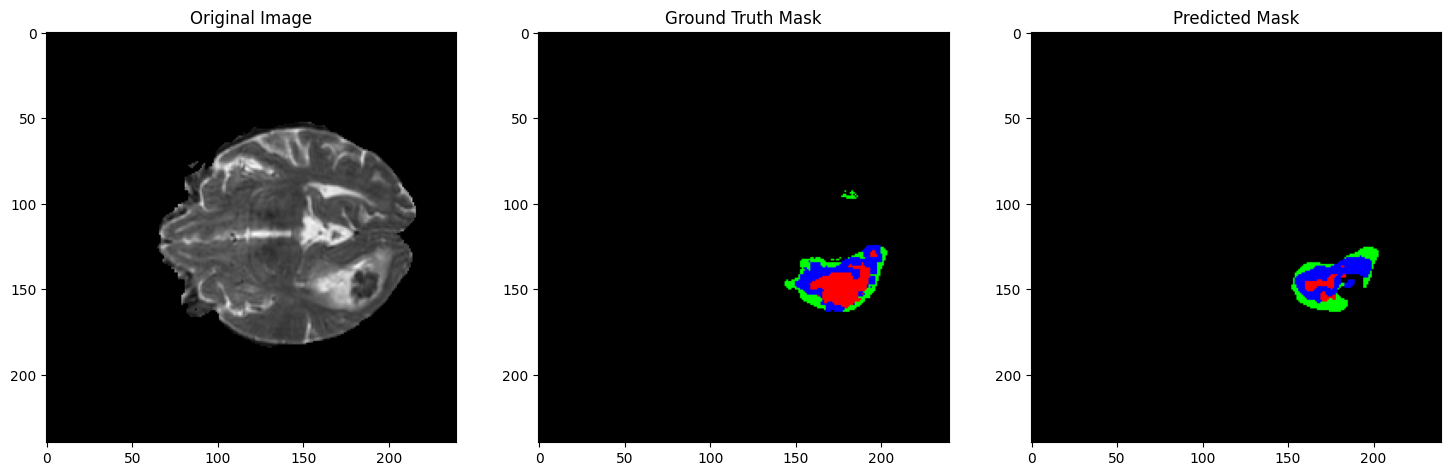

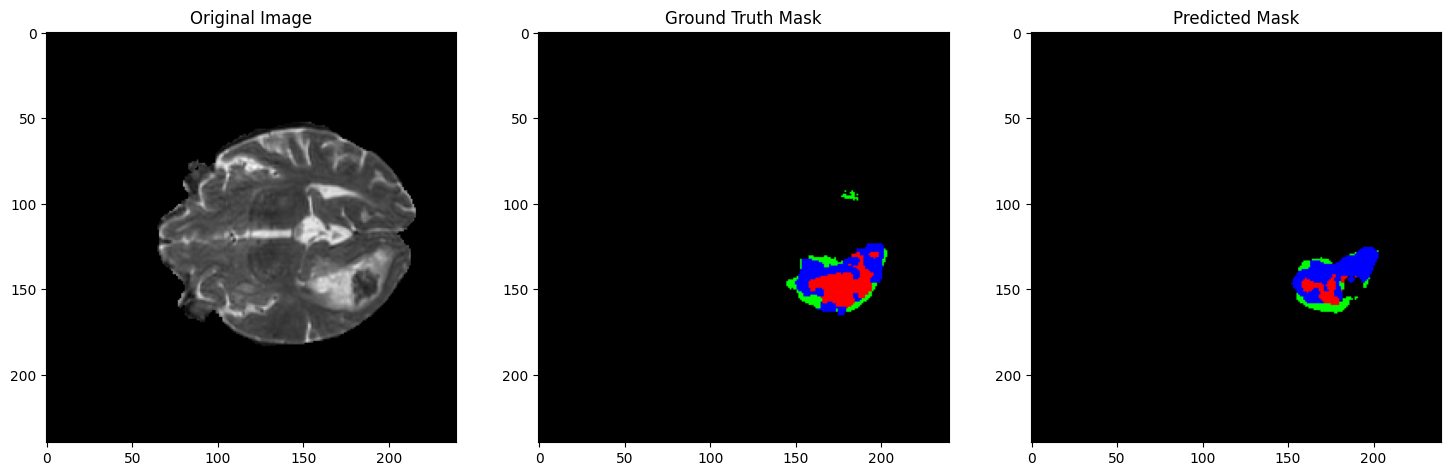

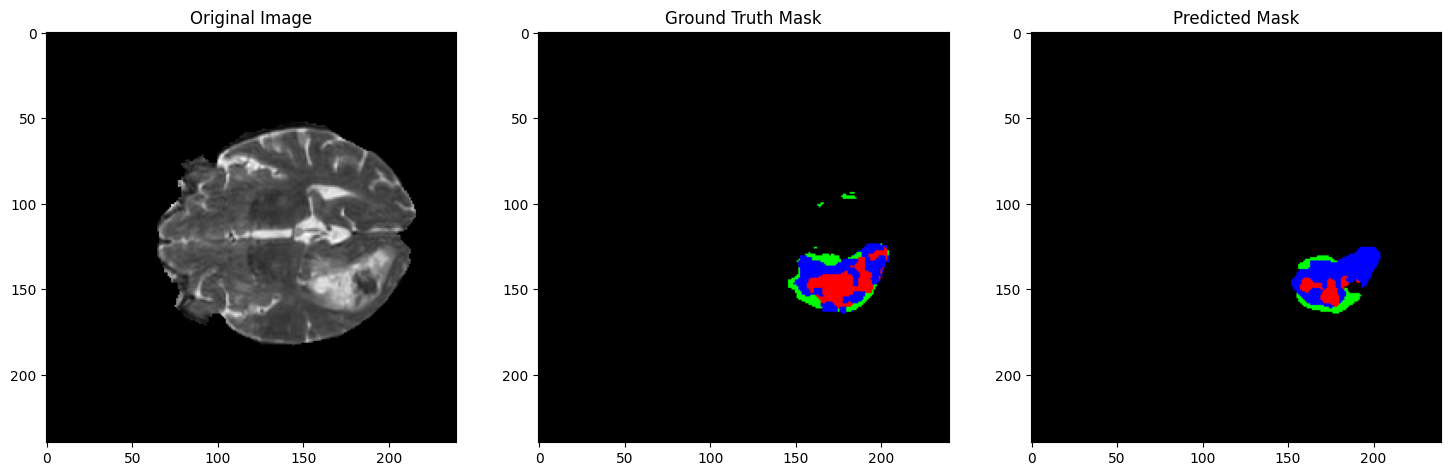

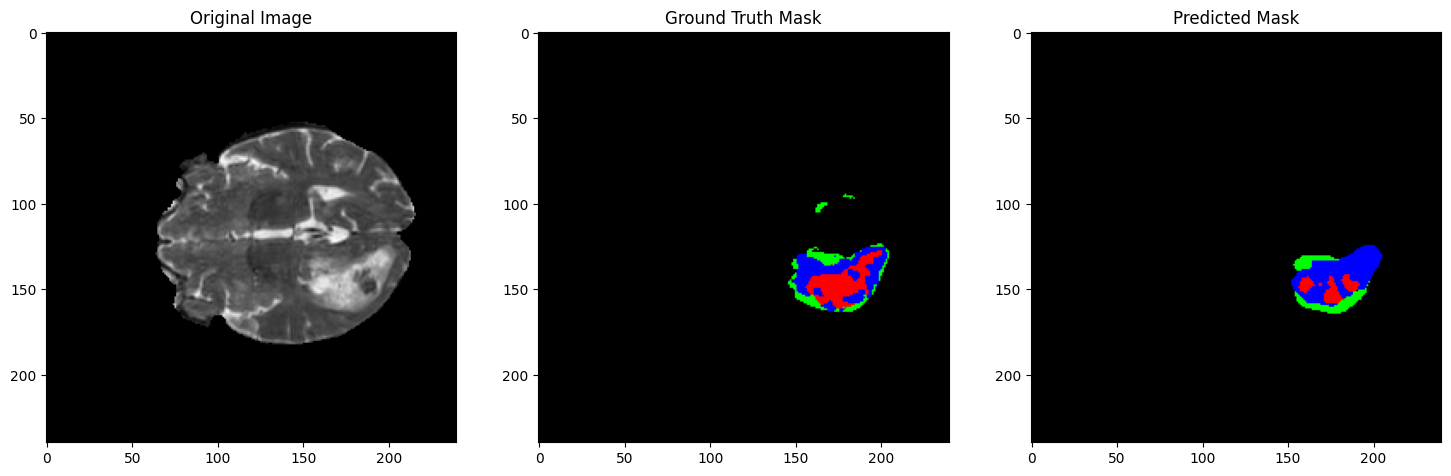

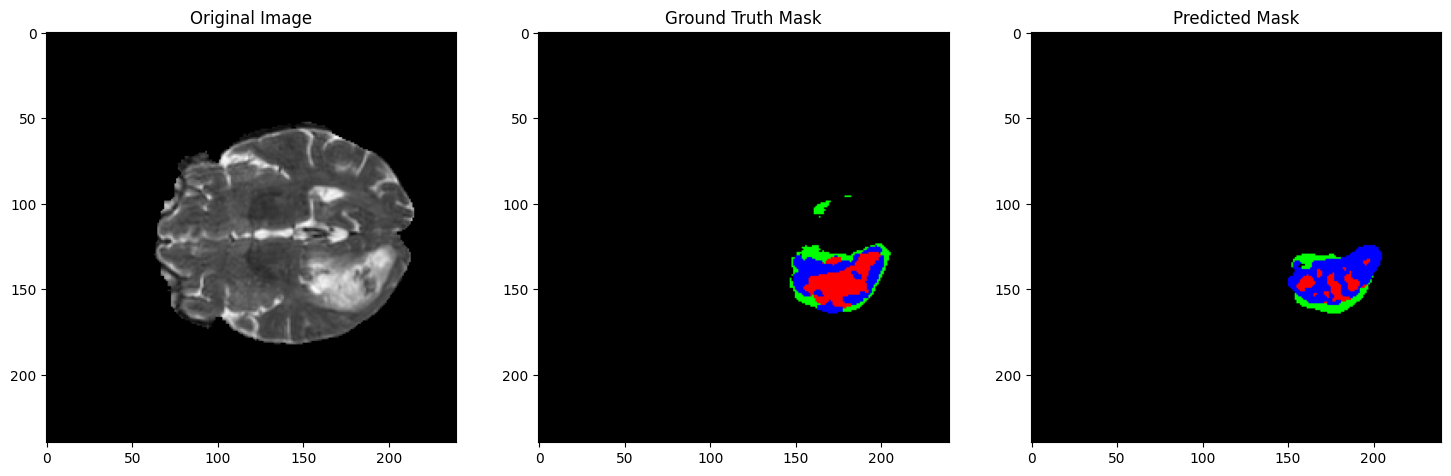

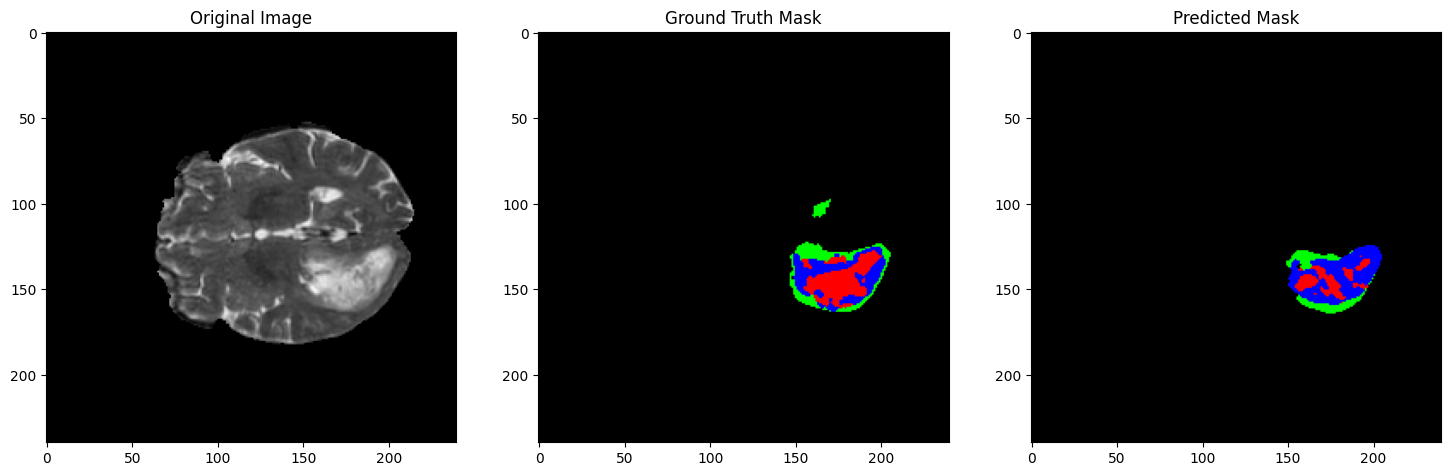

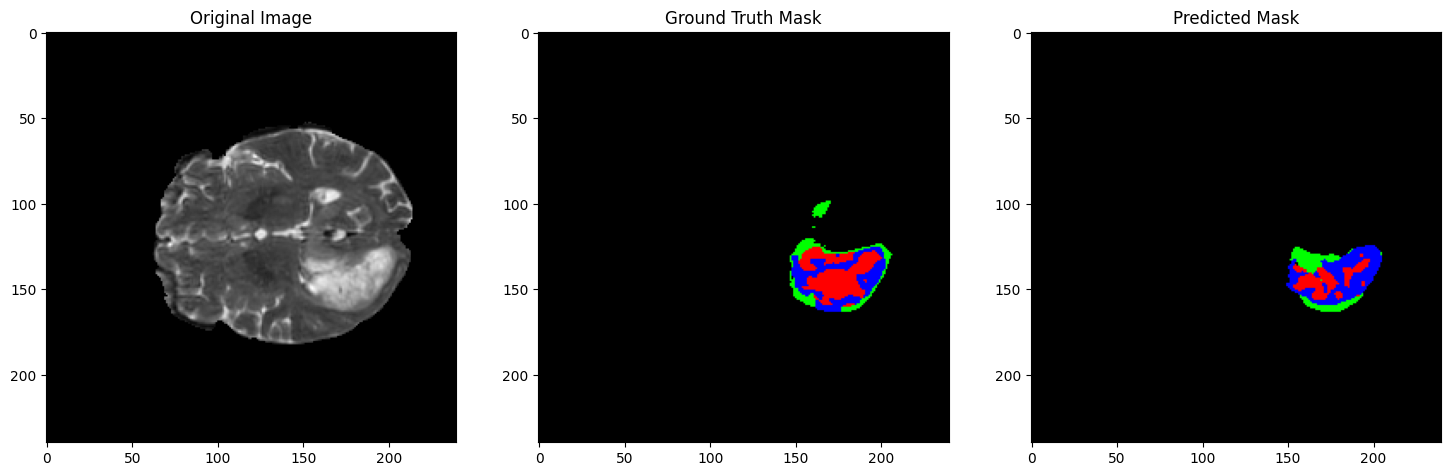

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

def apply_colormap_on_mask(mask, colormap):
    """
    mask: 2D array, 각 픽셀의 라벨을 담고 있는 배열
    colormap: dict, 라벨과 RGB 색상의 매핑을 담고 있는 사전
    """
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)  # RGB 이미지 생성
    for label, color in colormap.items():
        colored_mask[mask == label] = color
    return colored_mask

colormap = {
    0: [0, 0, 0],  # 배경
    1: [255, 0, 0],  # 클래스 1
    2: [0, 255, 0],  # 클래스 2
    3: [0, 0, 255]   # 클래스 3 등등 필요한 만큼 클래스 추가
}

# 이미지 카운터 초기화
image_counter = 0

# 모델 평가 모드 설정
model.eval()

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
   
        # 예측 결과 처리
        _, y_max_indices = torch.max(y, 1)  # y에 대한 최대값 인덱스 구하기
        _, predicted = torch.max(y_pred, 1)  # y_pred에 대한 최대값 인덱스 구하기

        # CPU로 데이터 이동 및 numpy 배열로 변환
        X_cpu = X.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()
        y_cpu = y_max_indices.cpu().numpy()  # 수정된 부분: 최대값 인덱스를 CPU로 이동 후 numpy 배열로 변환

        # 시각화
        for i in range(X_cpu.shape[0]):
            fig, ax = plt.subplots(1, 3, figsize=(18, 6))

            # 원본 이미지 시각화
            ax[0].imshow(np.transpose(X_cpu[i], (1, 2, 0)), cmap='gray')
            ax[0].set_title("Original Image")

            # 실제 마스크에 색상 적용
            ground_truth_colored = apply_colormap_on_mask(y_cpu[i], colormap)  # 수정된 부분: 첫 번째 채널만 사용하는 대신 전체 사용
            ax[1].imshow(ground_truth_colored)
            ax[1].set_title("Ground Truth Mask")

            # 예측 마스크에 색상 적용
            predicted_colored = apply_colormap_on_mask(predicted_cpu[i], colormap)
            ax[2].imshow(predicted_colored)
            ax[2].set_title("Predicted Mask")

            plt.show()

            # 이미지 카운터 업데이트
            image_counter += 1
            if image_counter >= 70:
                break

        if image_counter >= 70:
            break
